# Assignment2

## Import Necessary Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report  # Add this line
import warnings
import torchvision.models as models
import torchvision.datasets as datasets

## Dataset Loading

In [2]:
# Set device (use MPS for Apple Silicon, CUDA for other GPUs)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Define the CIFAR-10 data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for compatibility with pre-trained models
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:12<00:00, 13.4MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Data Visualisation

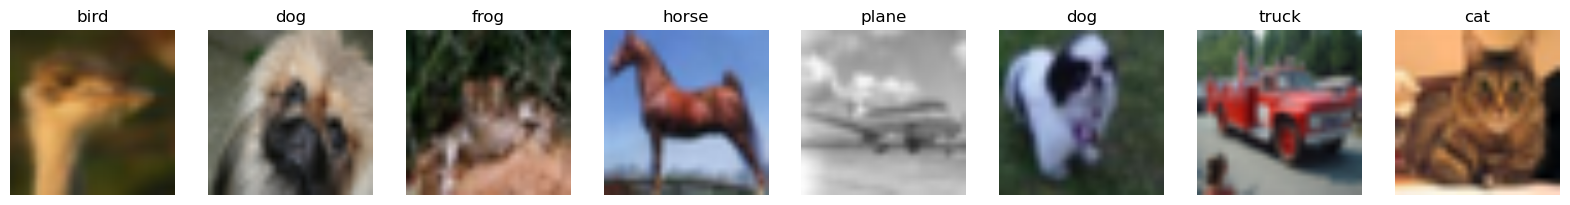

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

def show_cifar10_examples(dataset, classes, num_images=8):
    # Set up the DataLoader to fetch 8 images randomly
    data_loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(data_loader))
    images = images / 2 + 0.5  # Unnormalize images
    np_images = images.numpy()

    plt.figure(figsize=(20, 10))  # Adjust the figure size to better display 8 images
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)  # Plot in a single row
        plt.imshow(np.transpose(np_images[i], (1, 2, 0)))
        plt.title(classes[labels[i]])
        plt.axis("off")
    plt.show()

# Define CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Show CIFAR-10 examples
show_cifar10_examples(full_train_dataset, classes)

## Set Hyperparameters

In [4]:
# Hyperparameters and configurations
batch_size = 32
subset_ratio = 1  # Use 100% of CIFAR-10 for training and validation
learning_rates = [0.1, 0.01, 0.001]
optimizers = ['adam', 'sgd']
weight_decays = [0, 0.0001, 0.001]  # Include 0 for no regularization and other values for L2 regularization
num_epochs = 20

## Data Split

In [5]:
# Use a subset of the training dataset
train_size = int(subset_ratio * len(full_train_dataset))
val_size = int(train_size * 0.2)  # Use 20% of the subset for validation
train_indices = np.random.choice(len(full_train_dataset), train_size, replace=False)
train_subset = Subset(full_train_dataset, train_indices)
val_subset, train_subset = random_split(train_subset, [val_size, train_size - val_size])

# Data loaders for the subsets
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Models for training

In [6]:
# Initialize model
def initialize_model(model_name):
    if model_name == 'ResNet18':
        model = models.resnet18(weights=None, num_classes=10)
    elif model_name == 'MobileNetV2':
        model = models.mobilenet_v2(weights=None, num_classes=10)
    elif model_name == 'VGG11':
        model = models.vgg11(weights=None, num_classes=10)
    return model.to(device)

# Initialize optimizer
def get_optimizer(model_parameters, optimizer_name, lr, weight_decay):
    if optimizer_name == 'adam':
        return optim.Adam(model_parameters, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'sgd':
        return optim.SGD(model_parameters, lr=lr, momentum=0.9, weight_decay=weight_decay)
        

## Function Definition

In [7]:

        
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0

    def check(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

# Training and validation function with early stopping
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    early_stopping = EarlyStopping(patience=3)
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_losses.append(running_loss / total)
        train_accuracies.append(100 * correct / total)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_losses.append(val_loss / total)
        val_accuracies.append(100 * correct / total)
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

        # Early stopping check
        if early_stopping.check(val_losses[-1]):
            print("Early stopping triggered")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

# Plot learning curve
def plot_learning_curve(train_losses, val_losses, train_accuracies, val_accuracies, title):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title} Accuracy Curve")
    plt.legend()
    plt.show()

# Evaluate model
def evaluate_metrics(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    accuracy = 100 * correct / total
    return accuracy

## Training and Fine-tuning 


Training ResNet18 with ADAM optimizer, Learning Rate: 0.1, Weight Decay: 0


Epoch 1/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.09it/s]


Train Loss: 2.1244, Train Acc: 20.21%, Val Loss: 1.9289, Val Acc: 26.17%


Epoch 2/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.00it/s]


Train Loss: 1.8143, Train Acc: 27.29%, Val Loss: 1.7807, Val Acc: 29.10%


Epoch 3/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.81it/s]


Train Loss: 1.7125, Train Acc: 30.82%, Val Loss: 1.7713, Val Acc: 31.66%


Epoch 4/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.67it/s]


Train Loss: 1.5536, Train Acc: 39.40%, Val Loss: 1.5249, Val Acc: 41.11%


Epoch 5/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.79it/s]


Train Loss: 1.3437, Train Acc: 49.12%, Val Loss: 1.3172, Val Acc: 51.98%


Epoch 6/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.86it/s]


Train Loss: 1.1680, Train Acc: 56.38%, Val Loss: 1.0975, Val Acc: 60.28%


Epoch 7/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.77it/s]


Train Loss: 1.0472, Train Acc: 61.17%, Val Loss: 1.0105, Val Acc: 63.22%


Epoch 8/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.85it/s]


Train Loss: 0.9531, Train Acc: 65.19%, Val Loss: 1.0188, Val Acc: 63.20%


Epoch 9/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.90it/s]


Train Loss: 0.8724, Train Acc: 68.28%, Val Loss: 1.0084, Val Acc: 64.19%


Epoch 10/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.13it/s]


Train Loss: 0.7892, Train Acc: 71.03%, Val Loss: 0.9095, Val Acc: 67.84%


Epoch 11/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.87it/s]


Train Loss: 0.6998, Train Acc: 74.47%, Val Loss: 0.9186, Val Acc: 68.57%


Epoch 12/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.12it/s]


Train Loss: 0.6406, Train Acc: 76.66%, Val Loss: 0.8635, Val Acc: 71.00%


Epoch 13/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.92it/s]


Train Loss: 0.5578, Train Acc: 79.78%, Val Loss: 0.8965, Val Acc: 71.01%


Epoch 14/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.76it/s]


Train Loss: 0.4949, Train Acc: 81.67%, Val Loss: 0.9615, Val Acc: 71.19%


Epoch 15/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.73it/s]


Train Loss: 0.4321, Train Acc: 84.33%, Val Loss: 0.9578, Val Acc: 71.63%
Early stopping triggered


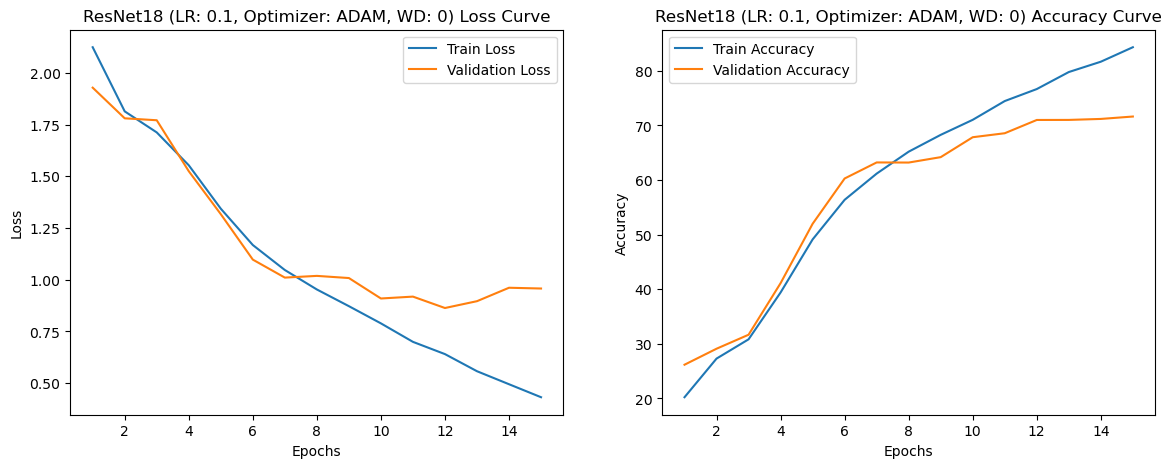


Training ResNet18 with ADAM optimizer, Learning Rate: 0.1, Weight Decay: 0.0001


Epoch 1/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.09it/s]


Train Loss: 2.2052, Train Acc: 19.72%, Val Loss: 2.1007, Val Acc: 20.82%


Epoch 2/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.95it/s]


Train Loss: 2.0162, Train Acc: 23.51%, Val Loss: 2.1736, Val Acc: 20.64%


Epoch 3/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.91it/s]


Train Loss: 1.9780, Train Acc: 25.28%, Val Loss: 4.8429, Val Acc: 9.91%


Epoch 4/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.92it/s]


Train Loss: 1.9847, Train Acc: 26.08%, Val Loss: 2.6175, Val Acc: 17.47%
Early stopping triggered


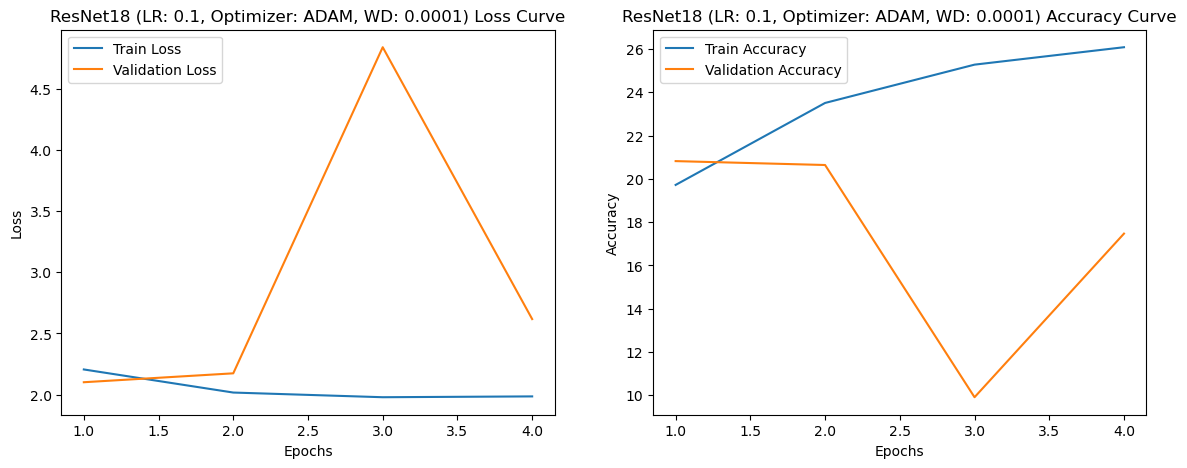


Training ResNet18 with ADAM optimizer, Learning Rate: 0.1, Weight Decay: 0.001


Epoch 1/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.01it/s]


Train Loss: 2.2512, Train Acc: 17.50%, Val Loss: 8.4981, Val Acc: 11.54%


Epoch 2/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.09it/s]


Train Loss: 2.2026, Train Acc: 17.39%, Val Loss: 2.8711, Val Acc: 7.23%


Epoch 3/20: 100%|██████████| 1250/1250 [01:06<00:00, 18.93it/s]


Train Loss: 2.2023, Train Acc: 16.89%, Val Loss: 4.1084, Val Acc: 10.74%


Epoch 4/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.11it/s]


Train Loss: 2.2380, Train Acc: 16.01%, Val Loss: 19.3085, Val Acc: 9.81%


Epoch 5/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.14it/s]


Train Loss: 2.2214, Train Acc: 16.65%, Val Loss: 2.3290, Val Acc: 15.01%


Epoch 6/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.01it/s]


Train Loss: 2.2123, Train Acc: 16.74%, Val Loss: 2.2527, Val Acc: 18.41%


Epoch 7/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.07it/s]


Train Loss: 2.2051, Train Acc: 17.42%, Val Loss: 3.4089, Val Acc: 10.53%


Epoch 8/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.01it/s]


Train Loss: 2.1977, Train Acc: 17.34%, Val Loss: 9.5986, Val Acc: 10.59%


Epoch 9/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.01it/s]


Train Loss: 2.2121, Train Acc: 16.77%, Val Loss: 3.1164, Val Acc: 6.41%
Early stopping triggered


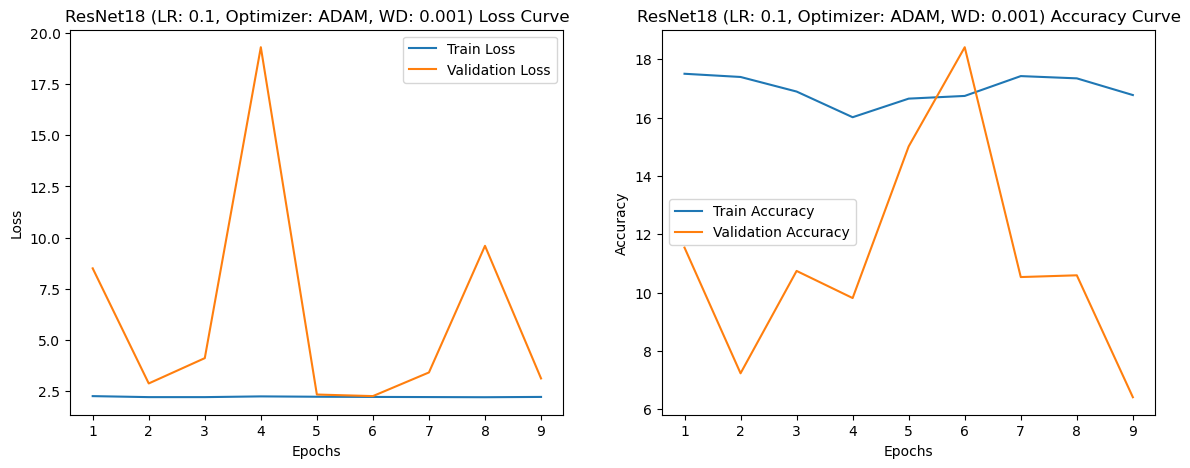


Training ResNet18 with SGD optimizer, Learning Rate: 0.1, Weight Decay: 0


Epoch 1/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.80it/s]


Train Loss: 1.8124, Train Acc: 33.82%, Val Loss: 1.4004, Val Acc: 48.09%


Epoch 2/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.68it/s]


Train Loss: 1.2741, Train Acc: 53.61%, Val Loss: 1.0581, Val Acc: 62.13%


Epoch 3/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.83it/s]


Train Loss: 0.9101, Train Acc: 67.94%, Val Loss: 0.8264, Val Acc: 71.08%


Epoch 4/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.75it/s]


Train Loss: 0.6866, Train Acc: 76.06%, Val Loss: 0.7433, Val Acc: 74.38%


Epoch 5/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.76it/s]


Train Loss: 0.5268, Train Acc: 81.48%, Val Loss: 0.5969, Val Acc: 79.33%


Epoch 6/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.67it/s]


Train Loss: 0.4148, Train Acc: 85.51%, Val Loss: 0.6618, Val Acc: 78.53%


Epoch 7/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.71it/s]


Train Loss: 0.3033, Train Acc: 89.45%, Val Loss: 0.6812, Val Acc: 79.05%


Epoch 8/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.78it/s]


Train Loss: 0.2246, Train Acc: 92.06%, Val Loss: 0.6336, Val Acc: 81.05%
Early stopping triggered


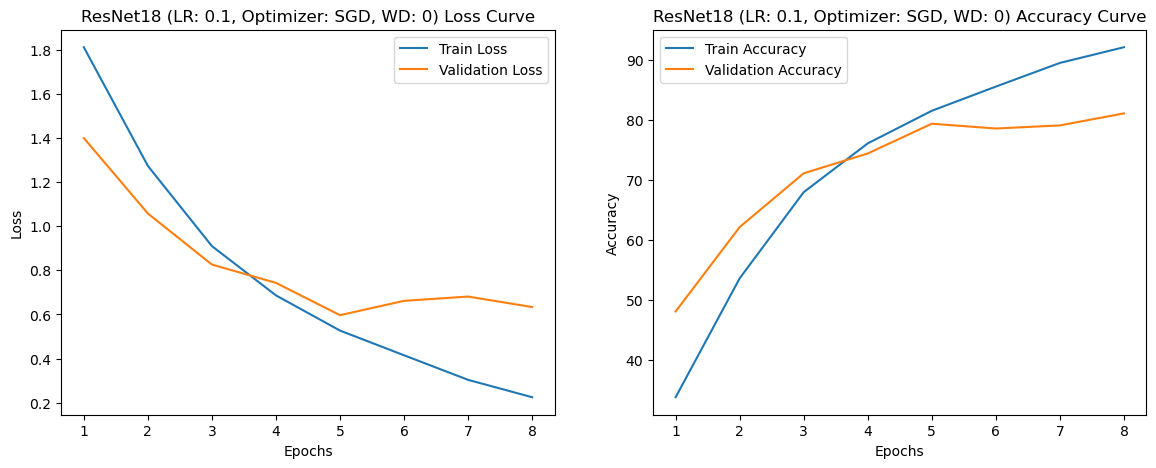


Training ResNet18 with SGD optimizer, Learning Rate: 0.1, Weight Decay: 0.0001


Epoch 1/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.72it/s]


Train Loss: 1.8605, Train Acc: 32.48%, Val Loss: 1.5062, Val Acc: 44.06%


Epoch 2/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.78it/s]


Train Loss: 1.2546, Train Acc: 54.51%, Val Loss: 1.0247, Val Acc: 63.24%


Epoch 3/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.93it/s]


Train Loss: 0.8919, Train Acc: 68.38%, Val Loss: 0.8698, Val Acc: 69.52%


Epoch 4/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.98it/s]


Train Loss: 0.6817, Train Acc: 76.42%, Val Loss: 0.7733, Val Acc: 73.71%


Epoch 5/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.73it/s]


Train Loss: 0.5522, Train Acc: 80.87%, Val Loss: 0.6740, Val Acc: 77.37%


Epoch 6/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.67it/s]


Train Loss: 0.4612, Train Acc: 83.96%, Val Loss: 0.6832, Val Acc: 77.02%


Epoch 7/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.77it/s]


Train Loss: 0.3991, Train Acc: 86.06%, Val Loss: 0.6157, Val Acc: 79.34%


Epoch 8/20: 100%|██████████| 1250/1250 [01:11<00:00, 17.57it/s]


Train Loss: 0.3416, Train Acc: 87.89%, Val Loss: 0.7380, Val Acc: 77.34%


Epoch 9/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.71it/s]


Train Loss: 0.2919, Train Acc: 89.86%, Val Loss: 0.6021, Val Acc: 80.70%


Epoch 10/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.73it/s]


Train Loss: 0.2534, Train Acc: 91.15%, Val Loss: 0.7405, Val Acc: 77.72%


Epoch 11/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.79it/s]


Train Loss: 0.2303, Train Acc: 91.95%, Val Loss: 0.6691, Val Acc: 79.45%


Epoch 12/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.77it/s]


Train Loss: 0.2125, Train Acc: 92.55%, Val Loss: 0.5866, Val Acc: 82.00%


Epoch 13/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.77it/s]


Train Loss: 0.1947, Train Acc: 93.20%, Val Loss: 0.7434, Val Acc: 79.41%


Epoch 14/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.80it/s]


Train Loss: 0.1853, Train Acc: 93.50%, Val Loss: 0.7192, Val Acc: 80.24%


Epoch 15/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.70it/s]


Train Loss: 0.1722, Train Acc: 94.10%, Val Loss: 0.6819, Val Acc: 80.86%
Early stopping triggered


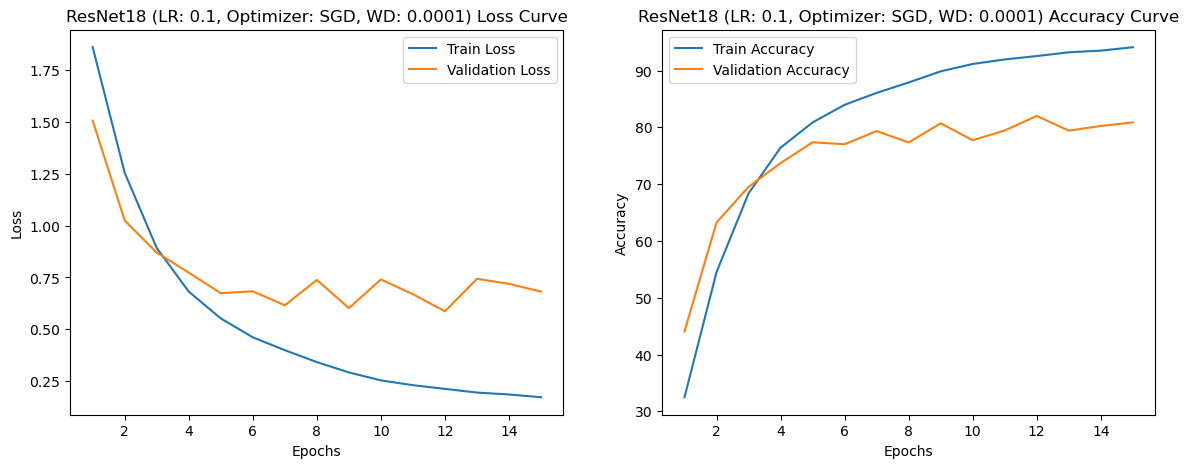


Training ResNet18 with SGD optimizer, Learning Rate: 0.1, Weight Decay: 0.001


Epoch 1/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.86it/s]


Train Loss: 1.9154, Train Acc: 31.04%, Val Loss: 1.6406, Val Acc: 39.57%


Epoch 2/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.87it/s]


Train Loss: 1.4491, Train Acc: 47.21%, Val Loss: 1.3980, Val Acc: 47.91%


Epoch 3/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.89it/s]


Train Loss: 1.2113, Train Acc: 56.91%, Val Loss: 1.2001, Val Acc: 58.56%


Epoch 4/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.77it/s]


Train Loss: 1.0640, Train Acc: 62.46%, Val Loss: 1.1269, Val Acc: 61.12%


Epoch 5/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.75it/s]


Train Loss: 0.9923, Train Acc: 65.53%, Val Loss: 1.3223, Val Acc: 55.21%


Epoch 6/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.79it/s]


Train Loss: 0.9460, Train Acc: 67.06%, Val Loss: 1.9111, Val Acc: 45.11%


Epoch 7/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.91it/s]


Train Loss: 0.9380, Train Acc: 67.83%, Val Loss: 1.0574, Val Acc: 63.05%


Epoch 8/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.88it/s]


Train Loss: 0.9203, Train Acc: 68.18%, Val Loss: 1.2009, Val Acc: 60.68%


Epoch 9/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.86it/s]


Train Loss: 0.9122, Train Acc: 68.04%, Val Loss: 0.9363, Val Acc: 67.24%


Epoch 10/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.82it/s]


Train Loss: 0.9003, Train Acc: 68.88%, Val Loss: 3.0785, Val Acc: 38.75%


Epoch 11/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.55it/s]


Train Loss: 0.8927, Train Acc: 69.30%, Val Loss: 1.1599, Val Acc: 61.19%


Epoch 12/20: 100%|██████████| 1250/1250 [01:06<00:00, 18.67it/s]


Train Loss: 0.8958, Train Acc: 69.00%, Val Loss: 1.1137, Val Acc: 63.27%
Early stopping triggered


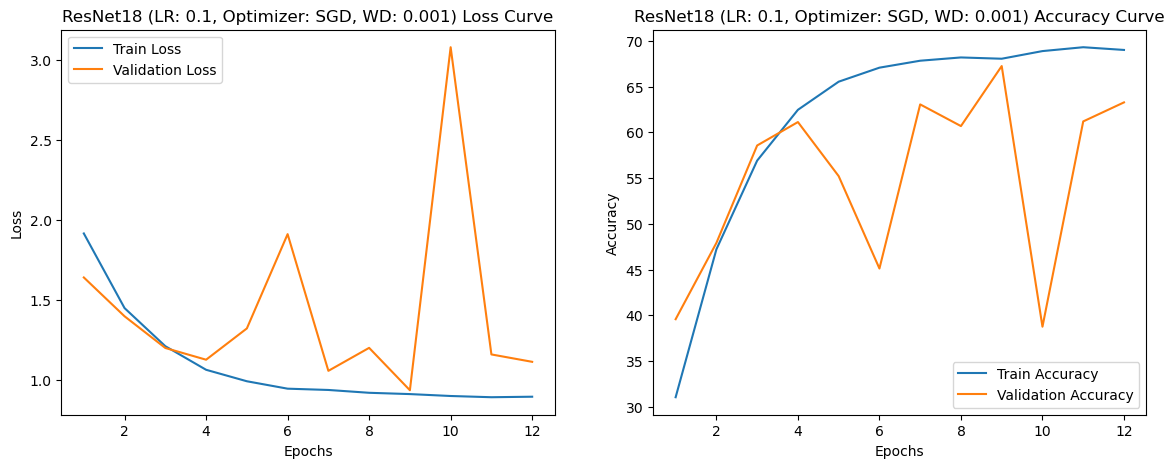


Training ResNet18 with ADAM optimizer, Learning Rate: 0.01, Weight Decay: 0


Epoch 1/20: 100%|██████████| 1250/1250 [01:06<00:00, 18.68it/s]


Train Loss: 1.7540, Train Acc: 35.28%, Val Loss: 1.4668, Val Acc: 46.09%


Epoch 2/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.44it/s]


Train Loss: 1.1875, Train Acc: 57.13%, Val Loss: 1.0775, Val Acc: 61.66%


Epoch 3/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.07it/s]


Train Loss: 0.8838, Train Acc: 68.74%, Val Loss: 0.7616, Val Acc: 73.16%


Epoch 4/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.94it/s]


Train Loss: 0.6806, Train Acc: 76.27%, Val Loss: 0.7972, Val Acc: 72.60%


Epoch 5/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.89it/s]


Train Loss: 0.5217, Train Acc: 81.89%, Val Loss: 0.6547, Val Acc: 78.09%


Epoch 6/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.78it/s]


Train Loss: 0.3824, Train Acc: 86.72%, Val Loss: 0.7384, Val Acc: 76.08%


Epoch 7/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.13it/s]


Train Loss: 0.2692, Train Acc: 90.41%, Val Loss: 0.7762, Val Acc: 77.19%


Epoch 8/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.05it/s]


Train Loss: 0.1891, Train Acc: 93.39%, Val Loss: 0.8181, Val Acc: 78.16%
Early stopping triggered


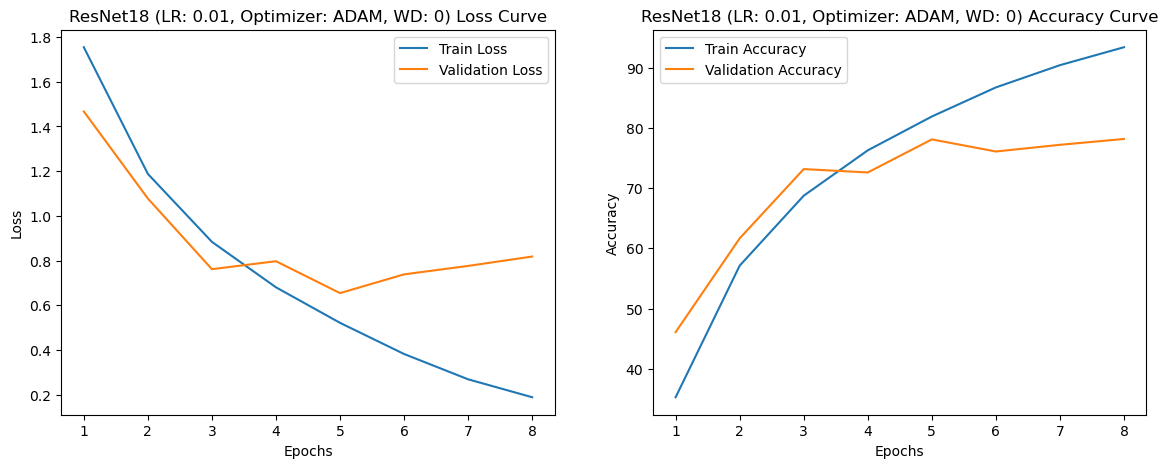


Training ResNet18 with ADAM optimizer, Learning Rate: 0.01, Weight Decay: 0.0001


Epoch 1/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.06it/s]


Train Loss: 1.8416, Train Acc: 31.45%, Val Loss: 1.5653, Val Acc: 42.55%


Epoch 2/20: 100%|██████████| 1250/1250 [01:06<00:00, 18.77it/s]


Train Loss: 1.4054, Train Acc: 48.53%, Val Loss: 1.2928, Val Acc: 52.85%


Epoch 3/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.62it/s]


Train Loss: 1.1840, Train Acc: 57.35%, Val Loss: 1.0911, Val Acc: 61.13%


Epoch 4/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.64it/s]


Train Loss: 1.0397, Train Acc: 62.87%, Val Loss: 1.2846, Val Acc: 57.70%


Epoch 5/20: 100%|██████████| 1250/1250 [01:06<00:00, 18.69it/s]


Train Loss: 0.9658, Train Acc: 65.65%, Val Loss: 0.9655, Val Acc: 66.24%


Epoch 6/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.57it/s]


Train Loss: 0.9175, Train Acc: 67.70%, Val Loss: 1.0436, Val Acc: 62.61%


Epoch 7/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.58it/s]


Train Loss: 0.8774, Train Acc: 69.06%, Val Loss: 0.9116, Val Acc: 67.40%


Epoch 8/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.55it/s]


Train Loss: 0.8546, Train Acc: 69.99%, Val Loss: 0.9109, Val Acc: 68.14%


Epoch 9/20: 100%|██████████| 1250/1250 [01:06<00:00, 18.70it/s]


Train Loss: 0.8396, Train Acc: 70.45%, Val Loss: 1.0102, Val Acc: 64.80%


Epoch 10/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.55it/s]


Train Loss: 0.8294, Train Acc: 71.09%, Val Loss: 0.8850, Val Acc: 69.00%


Epoch 11/20: 100%|██████████| 1250/1250 [01:06<00:00, 18.80it/s]


Train Loss: 0.8106, Train Acc: 71.73%, Val Loss: 0.8927, Val Acc: 69.01%


Epoch 12/20: 100%|██████████| 1250/1250 [01:06<00:00, 18.77it/s]


Train Loss: 0.8029, Train Acc: 71.98%, Val Loss: 0.9168, Val Acc: 68.26%


Epoch 13/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.60it/s]


Train Loss: 0.8006, Train Acc: 71.79%, Val Loss: 0.8681, Val Acc: 69.56%


Epoch 14/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.57it/s]


Train Loss: 0.7935, Train Acc: 72.31%, Val Loss: 0.9124, Val Acc: 68.27%


Epoch 15/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.49it/s]


Train Loss: 0.7851, Train Acc: 72.66%, Val Loss: 0.9761, Val Acc: 65.80%


Epoch 16/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.53it/s]


Train Loss: 0.7802, Train Acc: 72.66%, Val Loss: 1.0007, Val Acc: 65.53%
Early stopping triggered


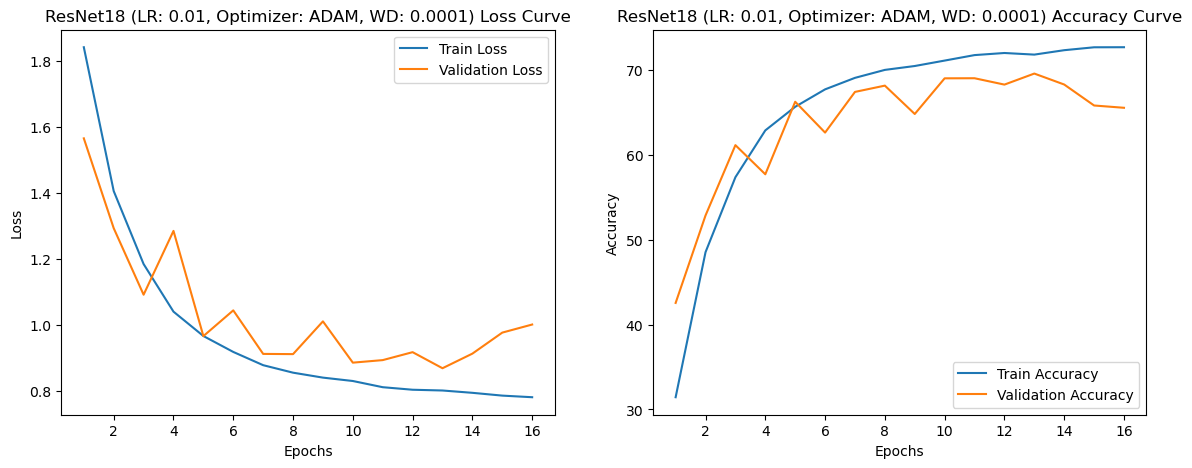


Training ResNet18 with ADAM optimizer, Learning Rate: 0.01, Weight Decay: 0.001


Epoch 1/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.47it/s]


Train Loss: 1.9093, Train Acc: 27.20%, Val Loss: 1.9632, Val Acc: 26.49%


Epoch 2/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.50it/s]


Train Loss: 1.6243, Train Acc: 38.83%, Val Loss: 1.7009, Val Acc: 38.42%


Epoch 3/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.45it/s]


Train Loss: 1.4574, Train Acc: 45.98%, Val Loss: 2.2454, Val Acc: 36.22%


Epoch 4/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.44it/s]


Train Loss: 1.3372, Train Acc: 51.27%, Val Loss: 3.0286, Val Acc: 23.73%


Epoch 5/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.40it/s]


Train Loss: 1.2832, Train Acc: 53.58%, Val Loss: 2.1387, Val Acc: 34.76%
Early stopping triggered


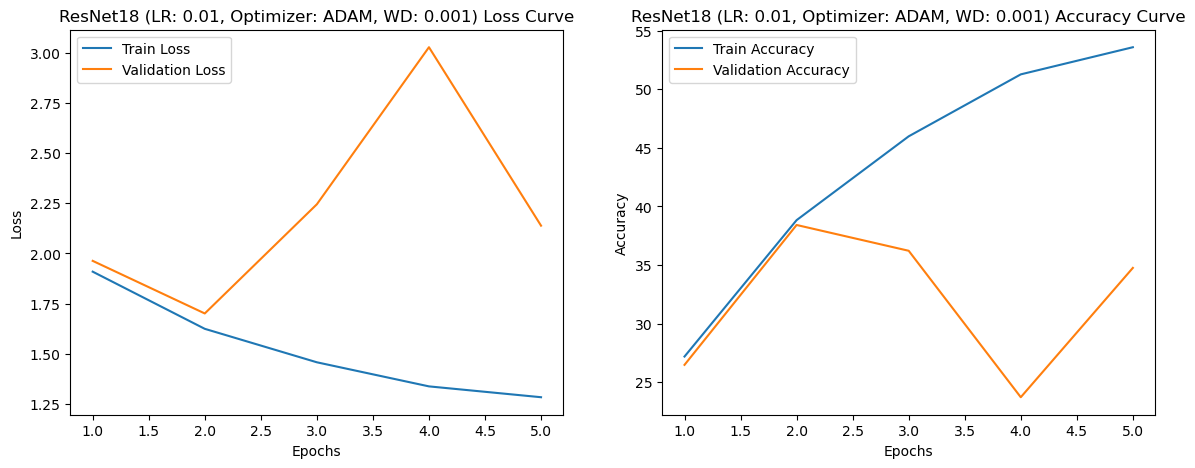


Training ResNet18 with SGD optimizer, Learning Rate: 0.01, Weight Decay: 0


Epoch 1/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.25it/s]


Train Loss: 1.5338, Train Acc: 44.65%, Val Loss: 1.1360, Val Acc: 59.84%


Epoch 2/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.20it/s]


Train Loss: 0.9422, Train Acc: 66.80%, Val Loss: 0.7735, Val Acc: 72.73%


Epoch 3/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.24it/s]


Train Loss: 0.6861, Train Acc: 76.03%, Val Loss: 0.7540, Val Acc: 74.36%


Epoch 4/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.40it/s]


Train Loss: 0.5243, Train Acc: 81.84%, Val Loss: 0.7015, Val Acc: 76.25%


Epoch 5/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.51it/s]


Train Loss: 0.3987, Train Acc: 86.22%, Val Loss: 0.6329, Val Acc: 78.99%


Epoch 6/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.00it/s]


Train Loss: 0.2924, Train Acc: 89.51%, Val Loss: 0.7451, Val Acc: 78.01%


Epoch 7/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.18it/s]


Train Loss: 0.1912, Train Acc: 93.33%, Val Loss: 0.7955, Val Acc: 77.82%


Epoch 8/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.32it/s]


Train Loss: 0.1507, Train Acc: 94.58%, Val Loss: 1.1621, Val Acc: 74.83%
Early stopping triggered


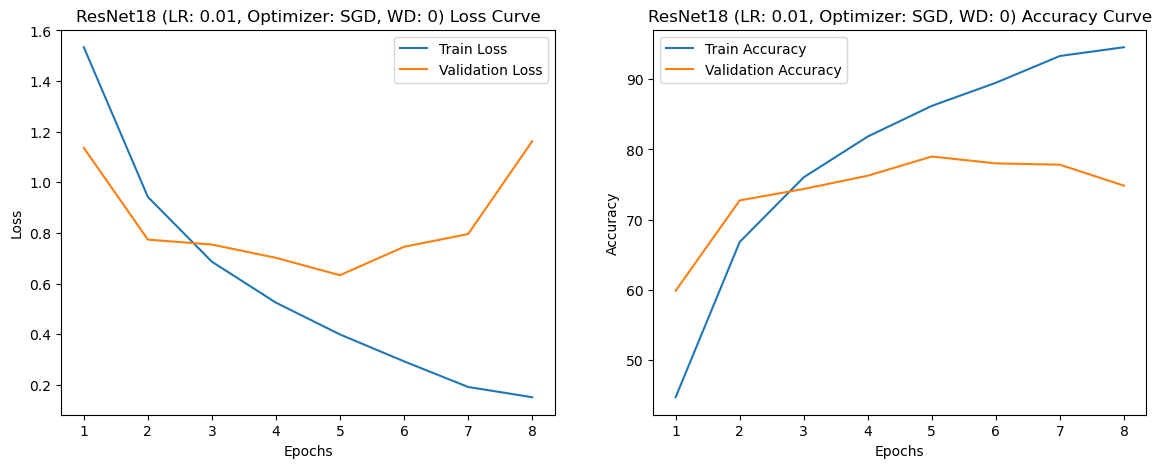


Training ResNet18 with SGD optimizer, Learning Rate: 0.01, Weight Decay: 0.0001


Epoch 1/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.41it/s]


Train Loss: 1.5280, Train Acc: 45.09%, Val Loss: 1.2614, Val Acc: 55.60%


Epoch 2/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.58it/s]


Train Loss: 0.9427, Train Acc: 66.65%, Val Loss: 0.9090, Val Acc: 68.64%


Epoch 3/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.37it/s]


Train Loss: 0.6986, Train Acc: 75.69%, Val Loss: 0.7731, Val Acc: 73.65%


Epoch 4/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.27it/s]


Train Loss: 0.5360, Train Acc: 81.33%, Val Loss: 0.8664, Val Acc: 72.93%


Epoch 5/20: 100%|██████████| 1250/1250 [01:06<00:00, 18.85it/s]


Train Loss: 0.4153, Train Acc: 85.49%, Val Loss: 0.7489, Val Acc: 76.26%


Epoch 6/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.97it/s]


Train Loss: 0.3075, Train Acc: 89.19%, Val Loss: 0.7410, Val Acc: 76.63%


Epoch 7/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.88it/s]


Train Loss: 0.2278, Train Acc: 92.07%, Val Loss: 0.7447, Val Acc: 78.51%


Epoch 8/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.75it/s]


Train Loss: 0.1629, Train Acc: 94.29%, Val Loss: 0.7887, Val Acc: 78.41%


Epoch 9/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.69it/s]


Train Loss: 0.1229, Train Acc: 95.73%, Val Loss: 0.7348, Val Acc: 80.43%


Epoch 10/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.72it/s]


Train Loss: 0.0861, Train Acc: 97.09%, Val Loss: 0.8137, Val Acc: 79.91%


Epoch 11/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.70it/s]


Train Loss: 0.0711, Train Acc: 97.62%, Val Loss: 0.8070, Val Acc: 79.62%


Epoch 12/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.83it/s]


Train Loss: 0.0603, Train Acc: 97.97%, Val Loss: 0.7893, Val Acc: 80.67%
Early stopping triggered


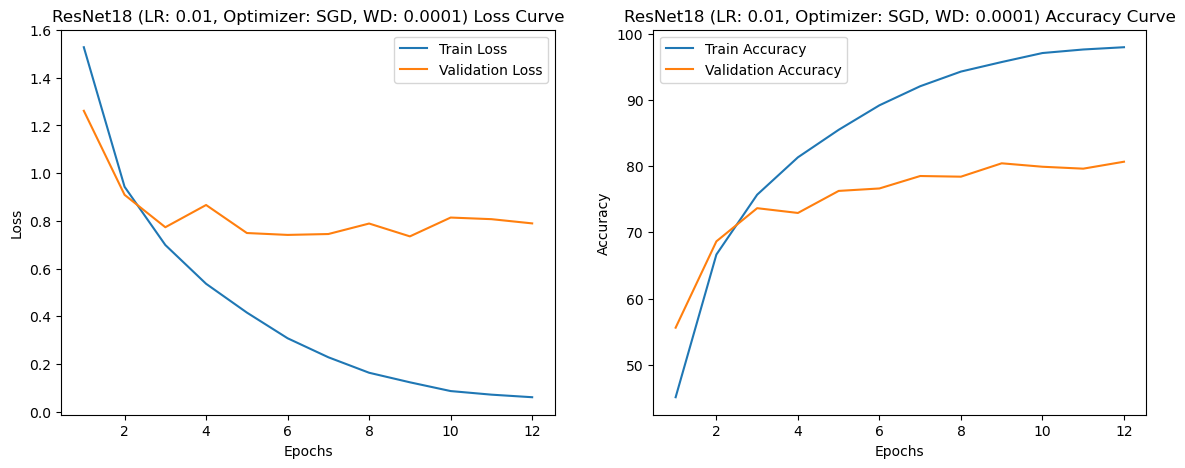


Training ResNet18 with SGD optimizer, Learning Rate: 0.01, Weight Decay: 0.001


Epoch 1/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.74it/s]


Train Loss: 1.4974, Train Acc: 46.20%, Val Loss: 1.2095, Val Acc: 58.24%


Epoch 2/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.64it/s]


Train Loss: 0.9029, Train Acc: 68.17%, Val Loss: 0.8716, Val Acc: 68.93%


Epoch 3/20: 100%|██████████| 1250/1250 [01:11<00:00, 17.53it/s]


Train Loss: 0.6745, Train Acc: 76.56%, Val Loss: 0.6407, Val Acc: 77.89%


Epoch 4/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.83it/s]


Train Loss: 0.5463, Train Acc: 81.19%, Val Loss: 0.7146, Val Acc: 76.26%


Epoch 5/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.97it/s]


Train Loss: 0.4594, Train Acc: 83.84%, Val Loss: 0.5422, Val Acc: 81.58%


Epoch 6/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.96it/s]


Train Loss: 0.3752, Train Acc: 87.05%, Val Loss: 0.5542, Val Acc: 81.47%


Epoch 7/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.95it/s]


Train Loss: 0.3155, Train Acc: 89.03%, Val Loss: 0.6476, Val Acc: 78.48%


Epoch 8/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.96it/s]


Train Loss: 0.2727, Train Acc: 90.61%, Val Loss: 0.7245, Val Acc: 78.18%
Early stopping triggered


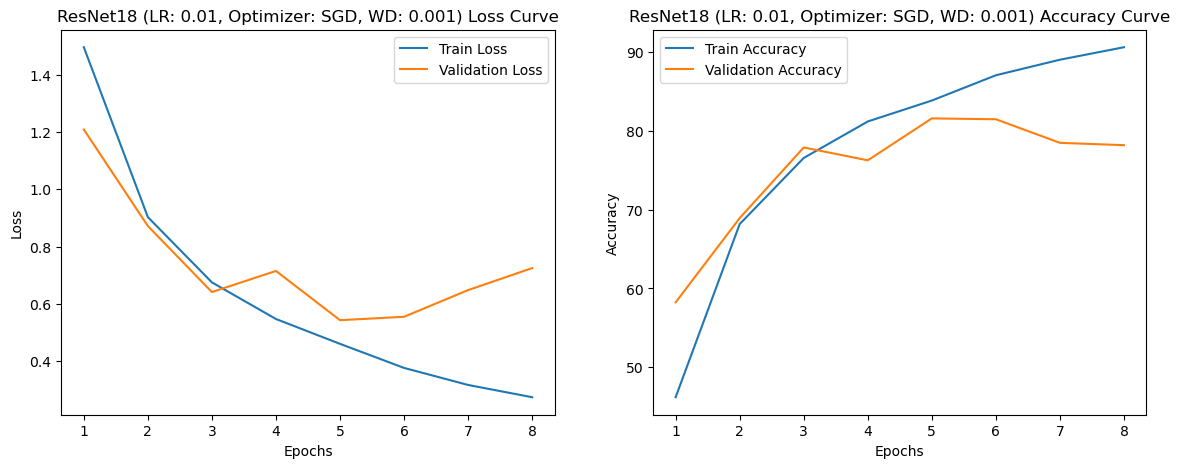


Training ResNet18 with ADAM optimizer, Learning Rate: 0.001, Weight Decay: 0


Epoch 1/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.88it/s]


Train Loss: 1.4518, Train Acc: 47.32%, Val Loss: 1.0512, Val Acc: 62.34%


Epoch 2/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.15it/s]


Train Loss: 0.9139, Train Acc: 67.87%, Val Loss: 0.7717, Val Acc: 72.76%


Epoch 3/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.97it/s]


Train Loss: 0.6944, Train Acc: 75.78%, Val Loss: 0.6669, Val Acc: 77.01%


Epoch 4/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.04it/s]


Train Loss: 0.5497, Train Acc: 81.00%, Val Loss: 0.6518, Val Acc: 77.99%


Epoch 5/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.04it/s]


Train Loss: 0.4346, Train Acc: 84.73%, Val Loss: 0.5714, Val Acc: 80.94%


Epoch 6/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.10it/s]


Train Loss: 0.3322, Train Acc: 88.45%, Val Loss: 0.5397, Val Acc: 82.79%


Epoch 7/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.10it/s]


Train Loss: 0.2459, Train Acc: 91.32%, Val Loss: 0.5520, Val Acc: 83.25%


Epoch 8/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.00it/s]


Train Loss: 0.1780, Train Acc: 93.72%, Val Loss: 0.5951, Val Acc: 82.60%


Epoch 9/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.02it/s]


Train Loss: 0.1317, Train Acc: 95.34%, Val Loss: 0.6500, Val Acc: 83.02%
Early stopping triggered


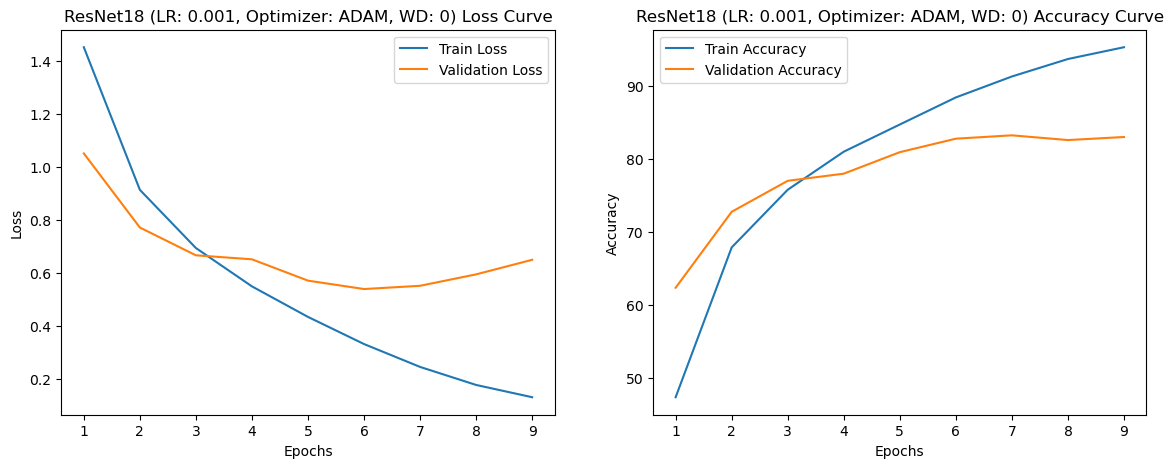


Training ResNet18 with ADAM optimizer, Learning Rate: 0.001, Weight Decay: 0.0001


Epoch 1/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.22it/s]


Train Loss: 1.4861, Train Acc: 45.57%, Val Loss: 1.6582, Val Acc: 45.31%


Epoch 2/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.11it/s]


Train Loss: 0.9983, Train Acc: 64.71%, Val Loss: 0.9056, Val Acc: 67.81%


Epoch 3/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.15it/s]


Train Loss: 0.7987, Train Acc: 72.34%, Val Loss: 0.9478, Val Acc: 67.44%


Epoch 4/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.09it/s]


Train Loss: 0.6968, Train Acc: 75.60%, Val Loss: 0.7821, Val Acc: 73.91%


Epoch 5/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.18it/s]


Train Loss: 0.6042, Train Acc: 79.11%, Val Loss: 0.8014, Val Acc: 72.98%


Epoch 6/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.03it/s]


Train Loss: 0.5267, Train Acc: 81.68%, Val Loss: 0.6697, Val Acc: 77.07%


Epoch 7/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.25it/s]


Train Loss: 0.4640, Train Acc: 84.11%, Val Loss: 0.5901, Val Acc: 79.85%


Epoch 8/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.22it/s]


Train Loss: 0.4064, Train Acc: 85.92%, Val Loss: 0.5734, Val Acc: 81.58%


Epoch 9/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.20it/s]


Train Loss: 0.3541, Train Acc: 87.68%, Val Loss: 0.5380, Val Acc: 82.37%


Epoch 10/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.97it/s]


Train Loss: 0.3087, Train Acc: 89.32%, Val Loss: 0.5332, Val Acc: 82.70%


Epoch 11/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.19it/s]


Train Loss: 0.2650, Train Acc: 90.73%, Val Loss: 0.5349, Val Acc: 82.69%


Epoch 12/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.21it/s]


Train Loss: 0.2356, Train Acc: 91.81%, Val Loss: 0.6352, Val Acc: 80.79%


Epoch 13/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.11it/s]


Train Loss: 0.2038, Train Acc: 92.79%, Val Loss: 0.5615, Val Acc: 82.47%
Early stopping triggered


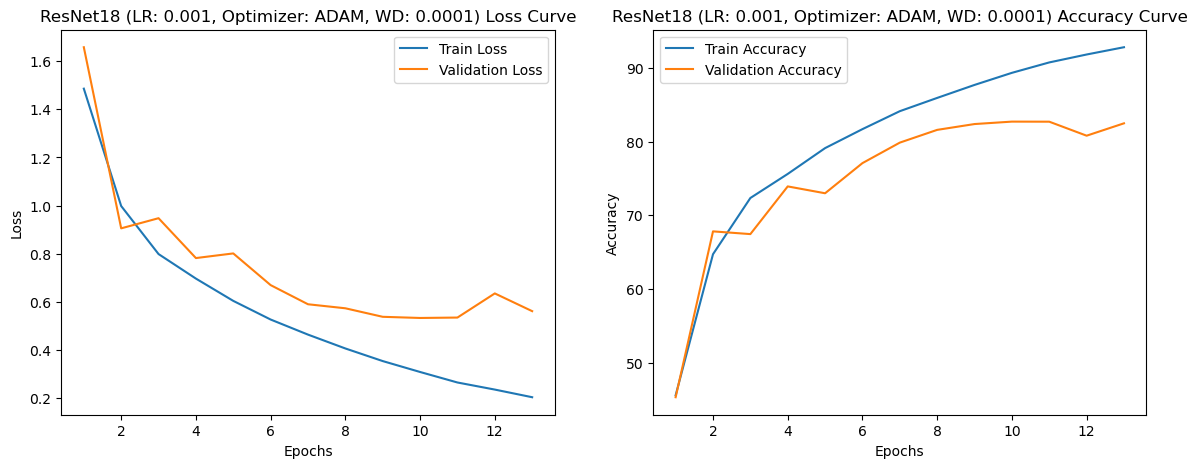


Training ResNet18 with ADAM optimizer, Learning Rate: 0.001, Weight Decay: 0.001


Epoch 1/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.09it/s]


Train Loss: 1.6233, Train Acc: 39.99%, Val Loss: 1.4890, Val Acc: 46.68%


Epoch 2/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.28it/s]


Train Loss: 1.2078, Train Acc: 56.76%, Val Loss: 1.4541, Val Acc: 52.34%


Epoch 3/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.22it/s]


Train Loss: 0.9978, Train Acc: 64.81%, Val Loss: 0.9486, Val Acc: 66.95%


Epoch 4/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.12it/s]


Train Loss: 0.8477, Train Acc: 70.60%, Val Loss: 0.7799, Val Acc: 72.46%


Epoch 5/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.07it/s]


Train Loss: 0.7498, Train Acc: 74.10%, Val Loss: 0.7544, Val Acc: 73.51%


Epoch 6/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.03it/s]


Train Loss: 0.6885, Train Acc: 76.16%, Val Loss: 0.7130, Val Acc: 75.13%


Epoch 7/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.91it/s]


Train Loss: 0.6411, Train Acc: 77.92%, Val Loss: 0.7257, Val Acc: 75.34%


Epoch 8/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.23it/s]


Train Loss: 0.5985, Train Acc: 79.39%, Val Loss: 0.6959, Val Acc: 76.27%


Epoch 9/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.18it/s]


Train Loss: 0.5702, Train Acc: 80.22%, Val Loss: 0.6694, Val Acc: 76.74%


Epoch 10/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.91it/s]


Train Loss: 0.5486, Train Acc: 81.34%, Val Loss: 0.6695, Val Acc: 77.35%


Epoch 11/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.16it/s]


Train Loss: 0.5228, Train Acc: 82.07%, Val Loss: 0.6610, Val Acc: 77.37%


Epoch 12/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.06it/s]


Train Loss: 0.5077, Train Acc: 82.70%, Val Loss: 0.6117, Val Acc: 79.03%


Epoch 13/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.10it/s]


Train Loss: 0.4873, Train Acc: 83.28%, Val Loss: 0.7430, Val Acc: 75.89%


Epoch 14/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.13it/s]


Train Loss: 0.4721, Train Acc: 83.78%, Val Loss: 0.6352, Val Acc: 78.84%


Epoch 15/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.10it/s]


Train Loss: 0.4566, Train Acc: 84.17%, Val Loss: 0.6752, Val Acc: 77.59%
Early stopping triggered


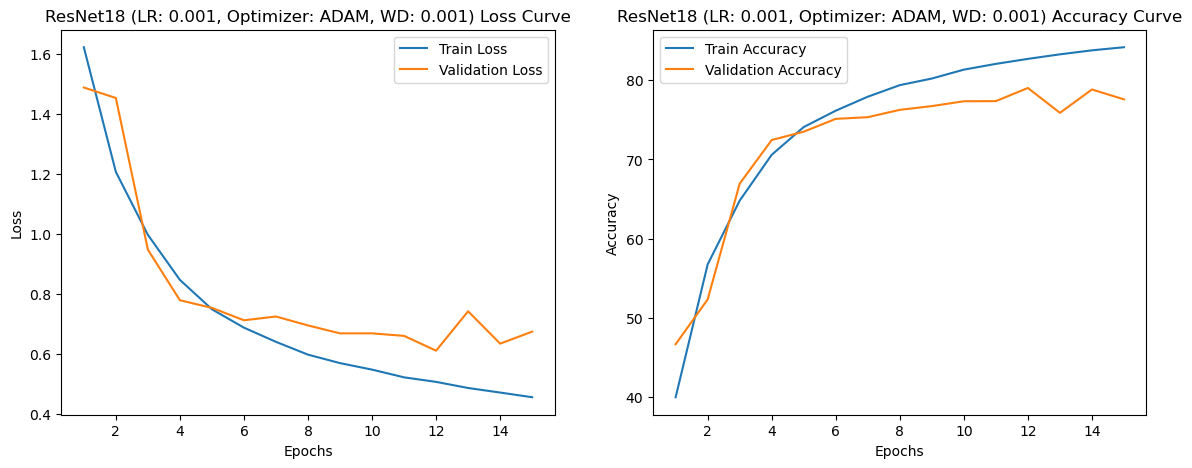


Training ResNet18 with SGD optimizer, Learning Rate: 0.001, Weight Decay: 0


Epoch 1/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.01it/s]


Train Loss: 1.6464, Train Acc: 39.00%, Val Loss: 1.3637, Val Acc: 50.45%


Epoch 2/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.00it/s]


Train Loss: 1.2851, Train Acc: 53.32%, Val Loss: 1.1944, Val Acc: 56.94%


Epoch 3/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.97it/s]


Train Loss: 1.0709, Train Acc: 61.54%, Val Loss: 1.1569, Val Acc: 59.95%


Epoch 4/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.04it/s]


Train Loss: 0.9121, Train Acc: 67.80%, Val Loss: 0.9041, Val Acc: 67.49%


Epoch 5/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.03it/s]


Train Loss: 0.7809, Train Acc: 72.42%, Val Loss: 0.8464, Val Acc: 70.00%


Epoch 6/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.01it/s]


Train Loss: 0.6476, Train Acc: 77.52%, Val Loss: 0.8486, Val Acc: 70.60%


Epoch 7/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.01it/s]


Train Loss: 0.5292, Train Acc: 81.58%, Val Loss: 0.8763, Val Acc: 70.72%


Epoch 8/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.01it/s]


Train Loss: 0.4153, Train Acc: 85.69%, Val Loss: 0.8582, Val Acc: 72.70%
Early stopping triggered


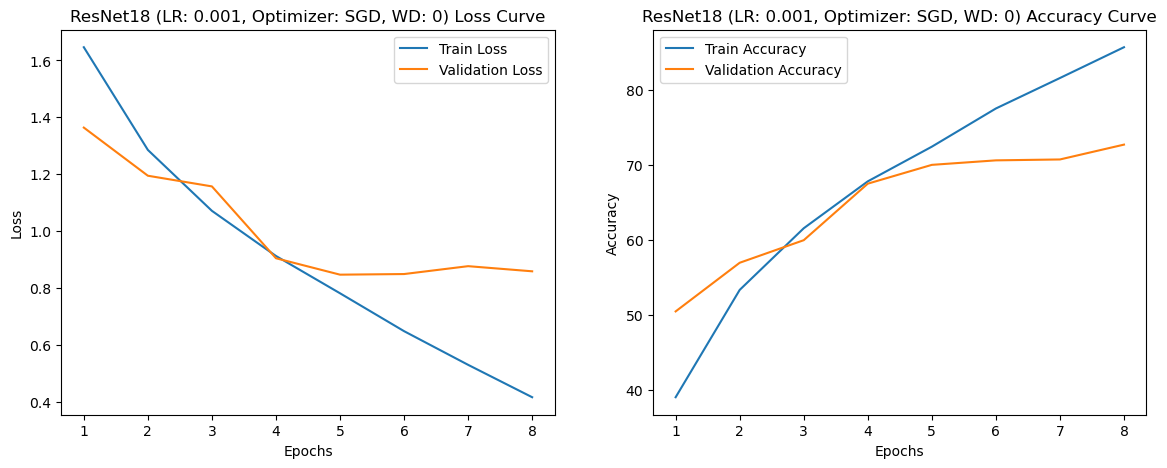


Training ResNet18 with SGD optimizer, Learning Rate: 0.001, Weight Decay: 0.0001


Epoch 1/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.05it/s]


Train Loss: 1.6329, Train Acc: 39.48%, Val Loss: 1.5133, Val Acc: 45.83%


Epoch 2/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.12it/s]


Train Loss: 1.2377, Train Acc: 54.87%, Val Loss: 1.4796, Val Acc: 49.47%


Epoch 3/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.10it/s]


Train Loss: 1.0257, Train Acc: 63.37%, Val Loss: 0.9737, Val Acc: 65.09%


Epoch 4/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.08it/s]


Train Loss: 0.8658, Train Acc: 69.32%, Val Loss: 0.9942, Val Acc: 65.26%


Epoch 5/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.02it/s]


Train Loss: 0.7425, Train Acc: 73.94%, Val Loss: 0.8437, Val Acc: 70.19%


Epoch 6/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.05it/s]


Train Loss: 0.6244, Train Acc: 78.14%, Val Loss: 0.8663, Val Acc: 70.51%


Epoch 7/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.09it/s]


Train Loss: 0.5020, Train Acc: 82.68%, Val Loss: 0.8022, Val Acc: 72.66%


Epoch 8/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.08it/s]


Train Loss: 0.3920, Train Acc: 86.63%, Val Loss: 1.0111, Val Acc: 69.94%


Epoch 9/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.12it/s]


Train Loss: 0.2899, Train Acc: 90.11%, Val Loss: 1.0680, Val Acc: 68.49%


Epoch 10/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.07it/s]


Train Loss: 0.1976, Train Acc: 93.75%, Val Loss: 1.1529, Val Acc: 69.94%
Early stopping triggered


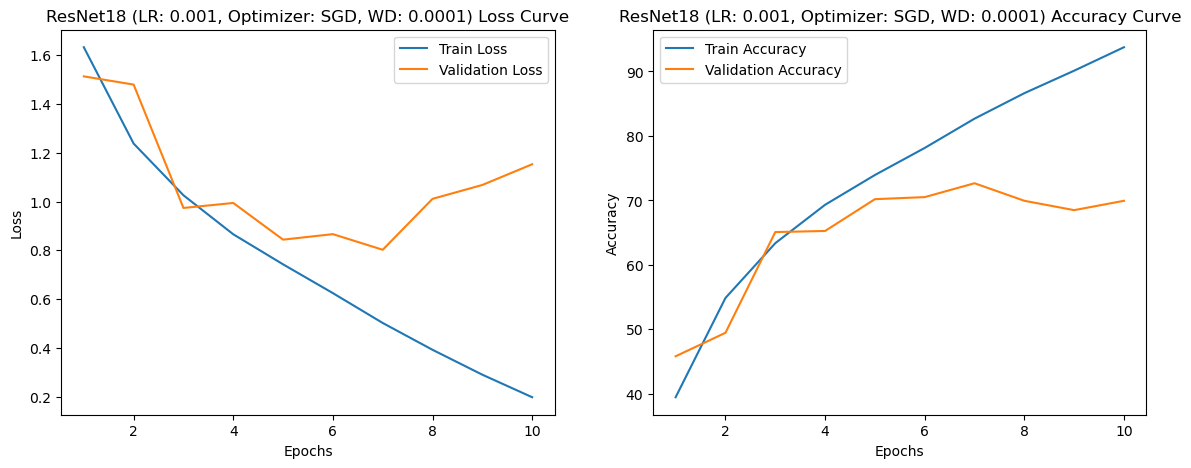


Training ResNet18 with SGD optimizer, Learning Rate: 0.001, Weight Decay: 0.001


Epoch 1/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.05it/s]


Train Loss: 1.6152, Train Acc: 40.42%, Val Loss: 1.4557, Val Acc: 46.54%


Epoch 2/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.09it/s]


Train Loss: 1.2129, Train Acc: 56.01%, Val Loss: 1.2259, Val Acc: 56.33%


Epoch 3/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.13it/s]


Train Loss: 1.0067, Train Acc: 64.22%, Val Loss: 0.9789, Val Acc: 64.83%


Epoch 4/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.11it/s]


Train Loss: 0.8514, Train Acc: 70.13%, Val Loss: 0.8908, Val Acc: 68.16%


Epoch 5/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.12it/s]


Train Loss: 0.7276, Train Acc: 74.55%, Val Loss: 0.7877, Val Acc: 71.61%


Epoch 6/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.10it/s]


Train Loss: 0.6092, Train Acc: 78.87%, Val Loss: 0.7871, Val Acc: 72.58%


Epoch 7/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.05it/s]


Train Loss: 0.4967, Train Acc: 82.93%, Val Loss: 0.8942, Val Acc: 70.01%


Epoch 8/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.07it/s]


Train Loss: 0.3928, Train Acc: 86.47%, Val Loss: 0.9304, Val Acc: 70.12%


Epoch 9/20: 100%|██████████| 1250/1250 [01:09<00:00, 18.08it/s]


Train Loss: 0.2946, Train Acc: 90.26%, Val Loss: 0.9182, Val Acc: 71.44%
Early stopping triggered


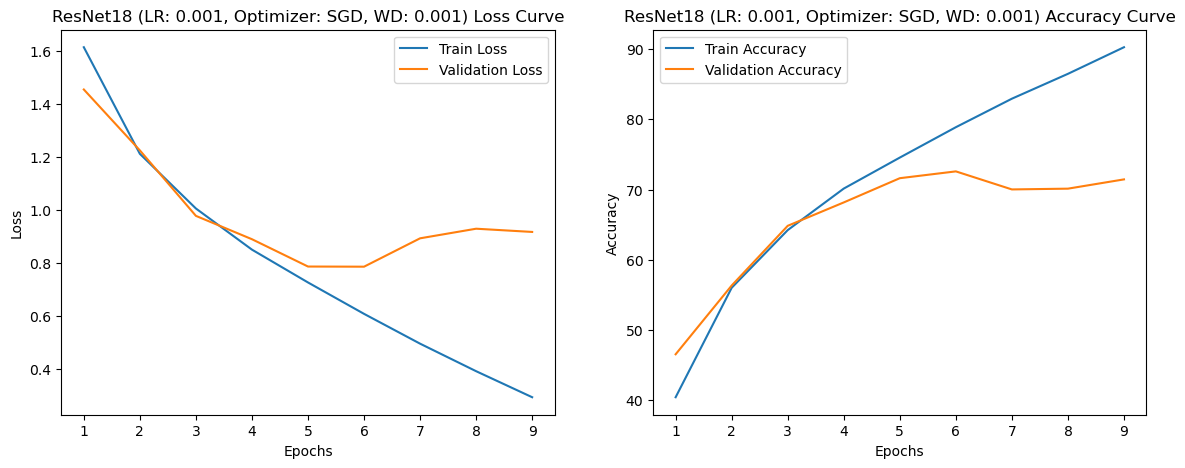


Best configuration for ResNet18 - Optimizer: ADAM, Learning Rate: 0.001, Weight Decay: 0, Validation Accuracy: 83.25%

Training MobileNetV2 with ADAM optimizer, Learning Rate: 0.1, Weight Decay: 0


Epoch 1/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.70it/s]


Train Loss: 2.1704, Train Acc: 20.00%, Val Loss: 1.8785, Val Acc: 22.98%


Epoch 2/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.69it/s]


Train Loss: 1.9030, Train Acc: 23.87%, Val Loss: 1.8043, Val Acc: 25.72%


Epoch 3/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 1.8730, Train Acc: 26.08%, Val Loss: 1.9197, Val Acc: 27.30%


Epoch 4/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.70it/s]


Train Loss: 1.9632, Train Acc: 23.71%, Val Loss: 1.9813, Val Acc: 23.43%


Epoch 5/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.76it/s]


Train Loss: 2.0916, Train Acc: 19.34%, Val Loss: 2.2273, Val Acc: 14.95%
Early stopping triggered


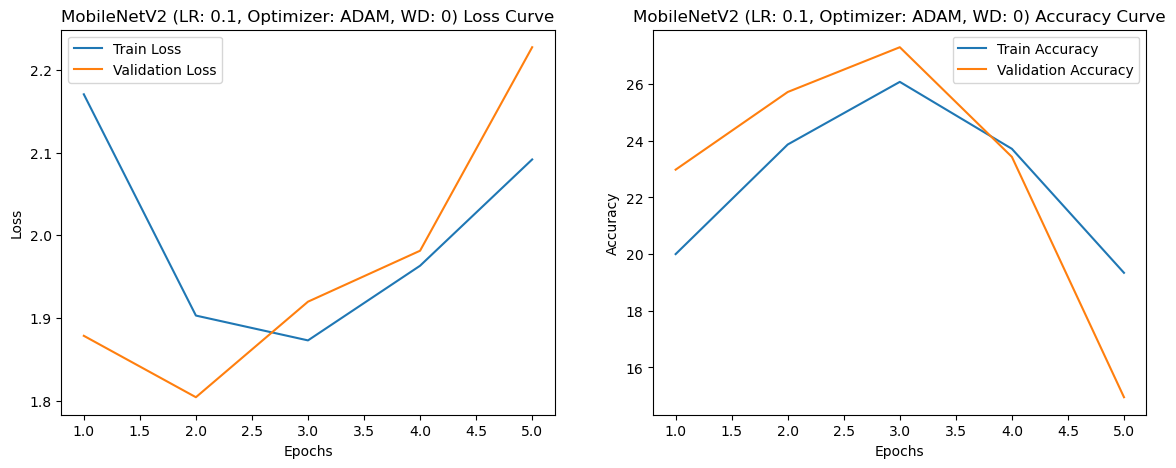


Training MobileNetV2 with ADAM optimizer, Learning Rate: 0.1, Weight Decay: 0.0001


Epoch 1/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 2.2259, Train Acc: 17.36%, Val Loss: 2.1740, Val Acc: 16.00%


Epoch 2/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 2.0579, Train Acc: 18.05%, Val Loss: 4.6374, Val Acc: 10.15%


Epoch 3/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.61it/s]


Train Loss: 2.0811, Train Acc: 17.57%, Val Loss: 2.4689, Val Acc: 16.40%


Epoch 4/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.70it/s]


Train Loss: 2.1276, Train Acc: 17.16%, Val Loss: 3.2630, Val Acc: 9.97%
Early stopping triggered


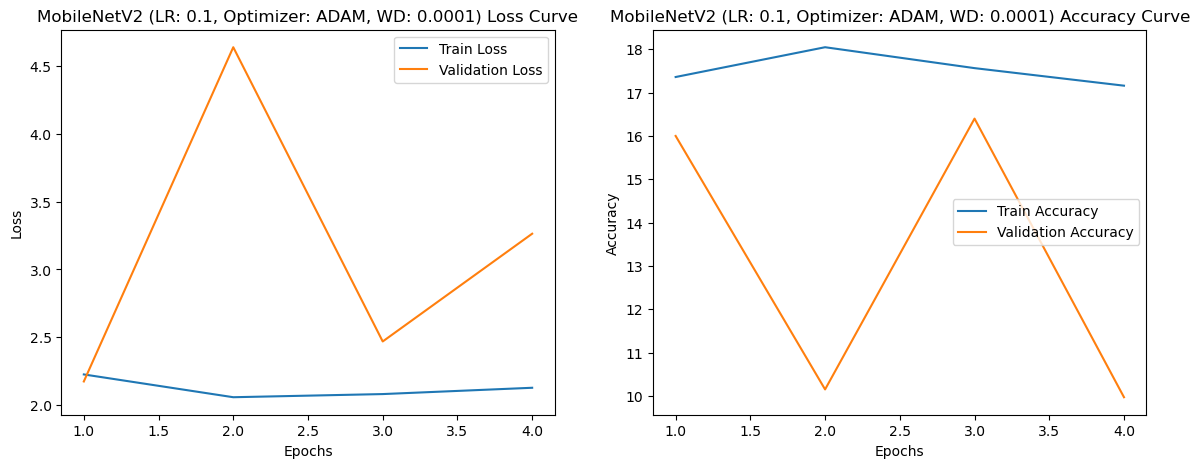


Training MobileNetV2 with ADAM optimizer, Learning Rate: 0.1, Weight Decay: 0.001


Epoch 1/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 2.2999, Train Acc: 15.97%, Val Loss: 2.3354, Val Acc: 10.74%


Epoch 2/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 2.2744, Train Acc: 13.02%, Val Loss: 2.3115, Val Acc: 9.81%


Epoch 3/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 2.3250, Train Acc: 9.99%, Val Loss: 2.3324, Val Acc: 10.37%


Epoch 4/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 2.3280, Train Acc: 9.81%, Val Loss: 2.3084, Val Acc: 9.40%


Epoch 5/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 2.3240, Train Acc: 9.97%, Val Loss: 2.3101, Val Acc: 9.95%


Epoch 6/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 2.3249, Train Acc: 9.89%, Val Loss: 2.3291, Val Acc: 10.37%


Epoch 7/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 2.3266, Train Acc: 10.04%, Val Loss: 2.3368, Val Acc: 10.74%
Early stopping triggered


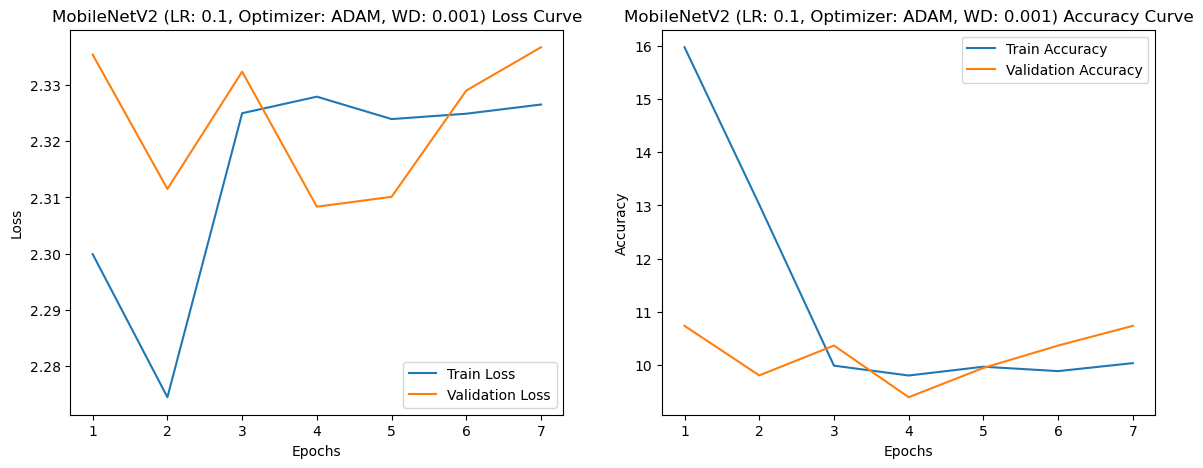


Training MobileNetV2 with SGD optimizer, Learning Rate: 0.1, Weight Decay: 0


Epoch 1/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.68it/s]


Train Loss: 1.8049, Train Acc: 34.93%, Val Loss: 1.4822, Val Acc: 44.73%


Epoch 2/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.69it/s]


Train Loss: 1.2576, Train Acc: 54.99%, Val Loss: 1.0226, Val Acc: 63.04%


Epoch 3/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 0.9489, Train Acc: 66.44%, Val Loss: 0.8287, Val Acc: 70.56%


Epoch 4/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.81it/s]


Train Loss: 0.7536, Train Acc: 73.88%, Val Loss: 0.6880, Val Acc: 76.07%


Epoch 5/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.77it/s]


Train Loss: 0.6191, Train Acc: 78.89%, Val Loss: 0.6187, Val Acc: 78.93%


Epoch 6/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.73it/s]


Train Loss: 0.5266, Train Acc: 82.03%, Val Loss: 0.5620, Val Acc: 81.31%


Epoch 7/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.76it/s]


Train Loss: 0.4491, Train Acc: 84.31%, Val Loss: 0.5494, Val Acc: 81.07%


Epoch 8/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.77it/s]


Train Loss: 0.3891, Train Acc: 86.57%, Val Loss: 0.5176, Val Acc: 82.83%


Epoch 9/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.76it/s]


Train Loss: 0.3432, Train Acc: 88.04%, Val Loss: 0.4980, Val Acc: 83.63%


Epoch 10/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.76it/s]


Train Loss: 0.2960, Train Acc: 89.70%, Val Loss: 0.5327, Val Acc: 82.59%


Epoch 11/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.78it/s]


Train Loss: 0.2607, Train Acc: 90.84%, Val Loss: 0.5283, Val Acc: 83.69%


Epoch 12/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.77it/s]


Train Loss: 0.2311, Train Acc: 91.80%, Val Loss: 0.4930, Val Acc: 84.72%


Epoch 13/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.74it/s]


Train Loss: 0.2119, Train Acc: 92.47%, Val Loss: 0.5322, Val Acc: 83.24%


Epoch 14/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.78it/s]


Train Loss: 0.1824, Train Acc: 93.62%, Val Loss: 0.4873, Val Acc: 85.22%


Epoch 15/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.77it/s]


Train Loss: 0.1626, Train Acc: 94.25%, Val Loss: 0.5731, Val Acc: 84.28%


Epoch 16/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.82it/s]


Train Loss: 0.1518, Train Acc: 94.61%, Val Loss: 0.5621, Val Acc: 84.79%


Epoch 17/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.77it/s]


Train Loss: 0.1281, Train Acc: 95.48%, Val Loss: 0.5489, Val Acc: 85.05%
Early stopping triggered


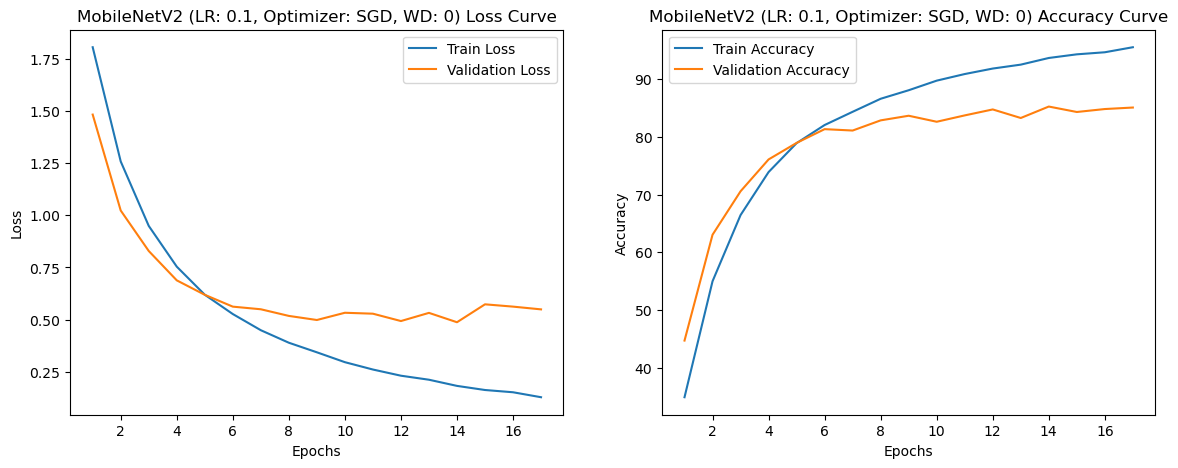


Training MobileNetV2 with SGD optimizer, Learning Rate: 0.1, Weight Decay: 0.0001


Epoch 1/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 1.8443, Train Acc: 33.75%, Val Loss: 1.4596, Val Acc: 45.80%


Epoch 2/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.71it/s]


Train Loss: 1.3075, Train Acc: 52.48%, Val Loss: 1.1623, Val Acc: 58.25%


Epoch 3/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.69it/s]


Train Loss: 0.9950, Train Acc: 64.99%, Val Loss: 0.8862, Val Acc: 69.42%


Epoch 4/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.68it/s]


Train Loss: 0.8191, Train Acc: 71.58%, Val Loss: 0.8050, Val Acc: 72.54%


Epoch 5/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.7092, Train Acc: 75.41%, Val Loss: 0.7033, Val Acc: 76.30%


Epoch 6/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.69it/s]


Train Loss: 0.6396, Train Acc: 77.93%, Val Loss: 0.6613, Val Acc: 77.28%


Epoch 7/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.71it/s]


Train Loss: 0.5963, Train Acc: 79.60%, Val Loss: 0.8773, Val Acc: 71.42%


Epoch 8/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 0.5629, Train Acc: 80.59%, Val Loss: 0.6231, Val Acc: 78.76%


Epoch 9/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.68it/s]


Train Loss: 0.5394, Train Acc: 81.41%, Val Loss: 0.6666, Val Acc: 77.57%


Epoch 10/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.68it/s]


Train Loss: 0.5250, Train Acc: 81.76%, Val Loss: 0.5971, Val Acc: 79.58%


Epoch 11/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 0.5093, Train Acc: 82.55%, Val Loss: 0.6158, Val Acc: 79.18%


Epoch 12/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 0.5028, Train Acc: 82.53%, Val Loss: 0.6229, Val Acc: 78.70%


Epoch 13/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 0.4956, Train Acc: 82.81%, Val Loss: 0.6178, Val Acc: 79.55%
Early stopping triggered


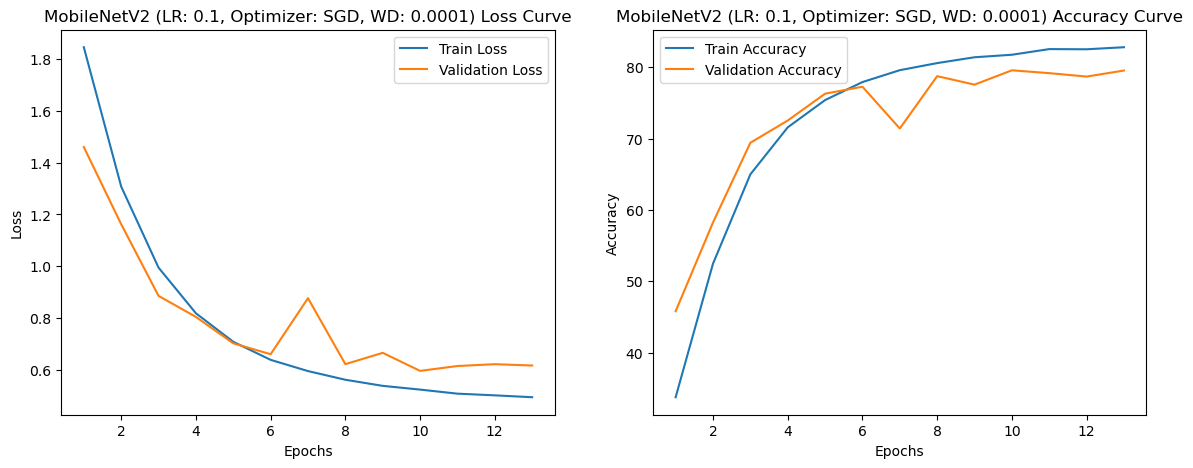


Training MobileNetV2 with SGD optimizer, Learning Rate: 0.1, Weight Decay: 0.001


Epoch 1/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 1.8689, Train Acc: 32.75%, Val Loss: 1.9471, Val Acc: 29.24%


Epoch 2/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.69it/s]


Train Loss: 1.4184, Train Acc: 48.38%, Val Loss: 3.3784, Val Acc: 22.76%


Epoch 3/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 1.3074, Train Acc: 53.54%, Val Loss: 1.7933, Val Acc: 38.16%


Epoch 4/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.72it/s]


Train Loss: 1.2609, Train Acc: 55.33%, Val Loss: 1.4503, Val Acc: 48.58%


Epoch 5/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.70it/s]


Train Loss: 1.2426, Train Acc: 56.59%, Val Loss: 1.4838, Val Acc: 49.99%


Epoch 6/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.69it/s]


Train Loss: 1.2428, Train Acc: 56.21%, Val Loss: 1.5627, Val Acc: 43.56%


Epoch 7/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 1.2439, Train Acc: 56.64%, Val Loss: 1.5291, Val Acc: 46.16%
Early stopping triggered


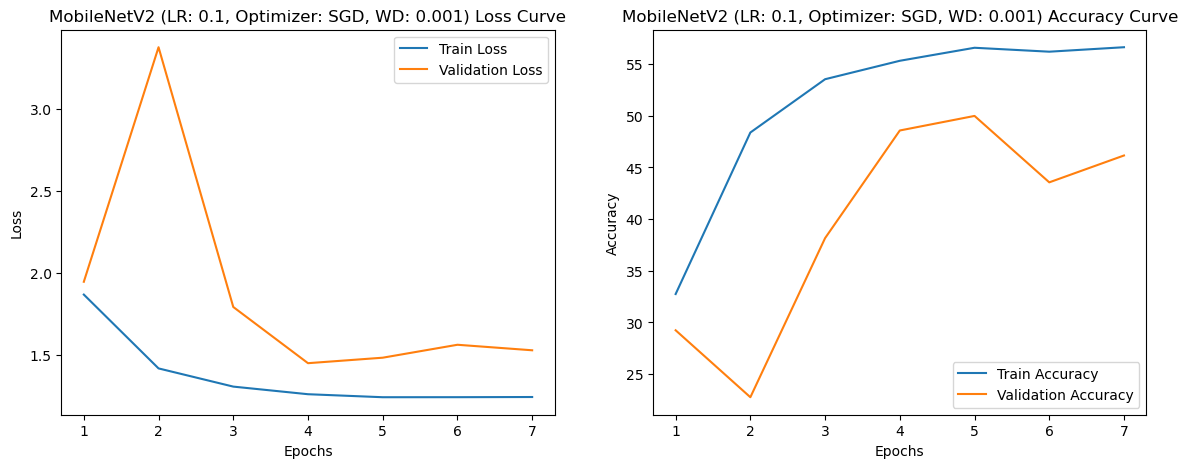


Training MobileNetV2 with ADAM optimizer, Learning Rate: 0.01, Weight Decay: 0


Epoch 1/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 1.7872, Train Acc: 32.38%, Val Loss: 1.5794, Val Acc: 42.27%


Epoch 2/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 1.3566, Train Acc: 50.26%, Val Loss: 1.2385, Val Acc: 55.90%


Epoch 3/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.62it/s]


Train Loss: 1.0921, Train Acc: 61.36%, Val Loss: 0.9546, Val Acc: 66.00%


Epoch 4/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.62it/s]


Train Loss: 0.9382, Train Acc: 67.21%, Val Loss: 0.9663, Val Acc: 65.90%


Epoch 5/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 0.8219, Train Acc: 71.55%, Val Loss: 0.7711, Val Acc: 73.16%


Epoch 6/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.59it/s]


Train Loss: 0.7447, Train Acc: 74.30%, Val Loss: 0.7510, Val Acc: 74.49%


Epoch 7/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.61it/s]


Train Loss: 0.6736, Train Acc: 76.82%, Val Loss: 0.6901, Val Acc: 76.14%


Epoch 8/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.61it/s]


Train Loss: 0.6253, Train Acc: 78.59%, Val Loss: 0.6889, Val Acc: 76.23%


Epoch 9/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 0.5815, Train Acc: 79.98%, Val Loss: 0.6851, Val Acc: 76.41%


Epoch 10/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 0.5426, Train Acc: 81.34%, Val Loss: 0.5916, Val Acc: 79.48%


Epoch 11/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.61it/s]


Train Loss: 0.5119, Train Acc: 82.42%, Val Loss: 0.5730, Val Acc: 80.36%


Epoch 12/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 0.4835, Train Acc: 83.38%, Val Loss: 0.5802, Val Acc: 80.37%


Epoch 13/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.61it/s]


Train Loss: 0.4514, Train Acc: 84.31%, Val Loss: 0.5881, Val Acc: 80.35%


Epoch 14/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.62it/s]


Train Loss: 0.4272, Train Acc: 85.24%, Val Loss: 0.5817, Val Acc: 80.72%
Early stopping triggered


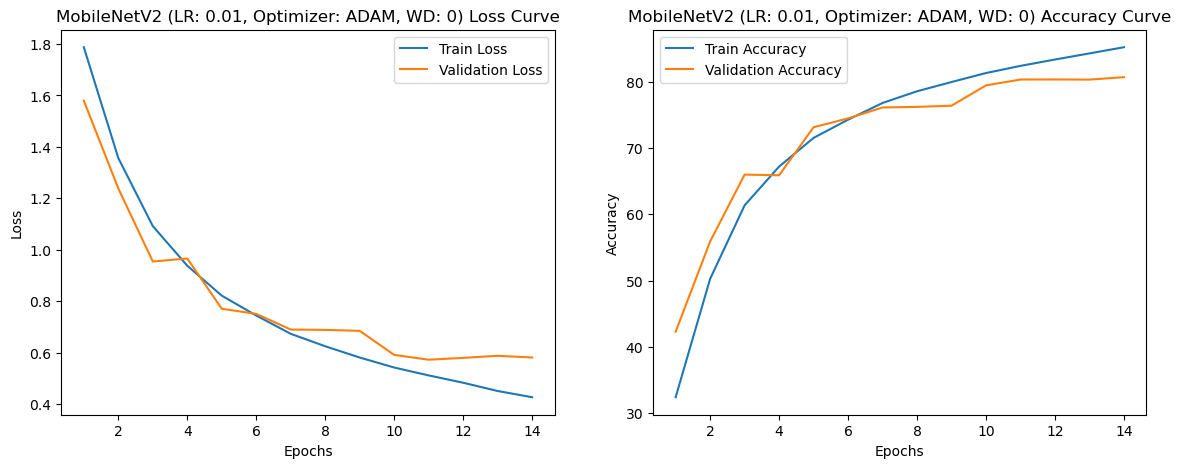


Training MobileNetV2 with ADAM optimizer, Learning Rate: 0.01, Weight Decay: 0.0001


Epoch 1/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 1.9025, Train Acc: 26.17%, Val Loss: 1.7353, Val Acc: 30.91%


Epoch 2/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 1.6146, Train Acc: 37.76%, Val Loss: 1.5141, Val Acc: 42.48%


Epoch 3/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 1.4199, Train Acc: 47.23%, Val Loss: 1.6168, Val Acc: 41.42%


Epoch 4/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 1.3263, Train Acc: 51.34%, Val Loss: 1.2993, Val Acc: 51.89%


Epoch 5/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.68it/s]


Train Loss: 1.2600, Train Acc: 54.19%, Val Loss: 1.2578, Val Acc: 54.18%


Epoch 6/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 1.2045, Train Acc: 56.84%, Val Loss: 1.3193, Val Acc: 53.96%


Epoch 7/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.61it/s]


Train Loss: 1.1722, Train Acc: 58.12%, Val Loss: 1.4583, Val Acc: 51.04%


Epoch 8/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 1.1447, Train Acc: 58.94%, Val Loss: 1.4036, Val Acc: 52.56%
Early stopping triggered


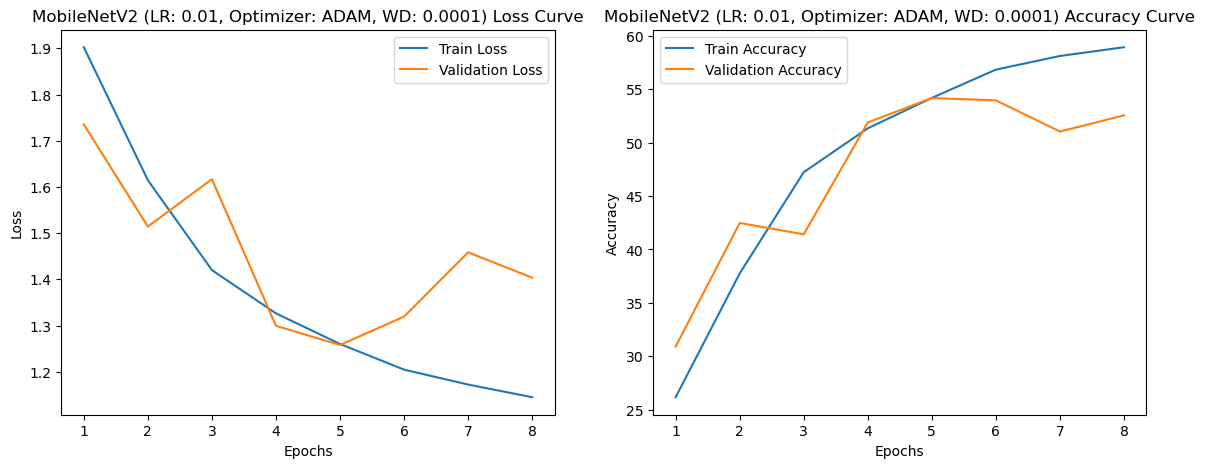


Training MobileNetV2 with ADAM optimizer, Learning Rate: 0.01, Weight Decay: 0.001


Epoch 1/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 1.9545, Train Acc: 22.93%, Val Loss: 2.5749, Val Acc: 14.61%


Epoch 2/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 1.7926, Train Acc: 29.68%, Val Loss: 1.8086, Val Acc: 28.67%


Epoch 3/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 1.7317, Train Acc: 32.99%, Val Loss: 1.9750, Val Acc: 27.61%


Epoch 4/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 1.6733, Train Acc: 35.88%, Val Loss: 2.0954, Val Acc: 24.30%


Epoch 5/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 1.6168, Train Acc: 39.25%, Val Loss: 1.7992, Val Acc: 33.99%


Epoch 6/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.74it/s]


Train Loss: 1.5902, Train Acc: 40.80%, Val Loss: 1.7241, Val Acc: 36.16%


Epoch 7/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 1.5798, Train Acc: 40.90%, Val Loss: 1.7495, Val Acc: 35.03%


Epoch 8/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 1.5731, Train Acc: 41.48%, Val Loss: 2.0183, Val Acc: 27.96%


Epoch 9/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 1.5522, Train Acc: 42.64%, Val Loss: 1.8816, Val Acc: 33.73%
Early stopping triggered


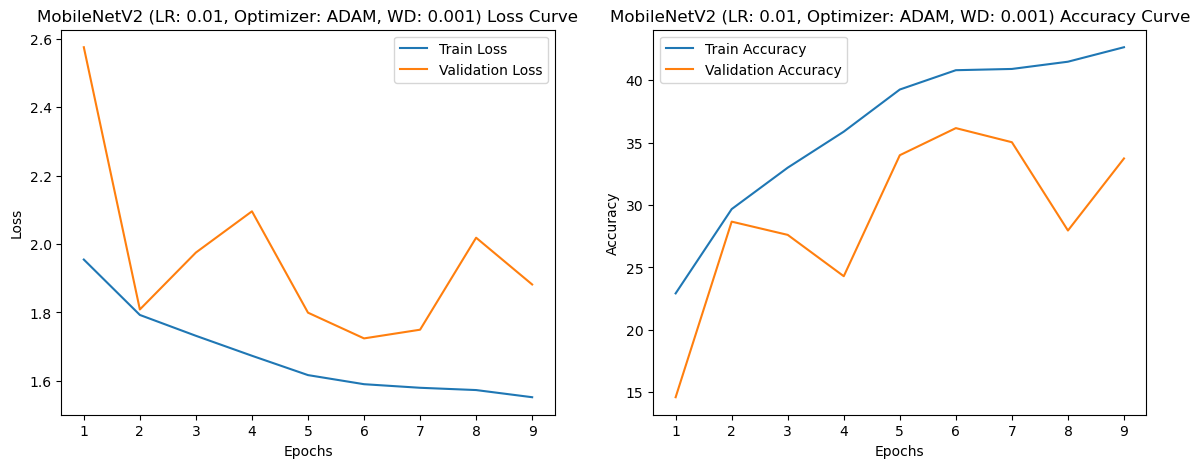


Training MobileNetV2 with SGD optimizer, Learning Rate: 0.01, Weight Decay: 0


Epoch 1/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.56it/s]


Train Loss: 1.6060, Train Acc: 41.95%, Val Loss: 1.1512, Val Acc: 59.80%


Epoch 2/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.56it/s]


Train Loss: 1.0176, Train Acc: 64.33%, Val Loss: 0.7924, Val Acc: 72.81%


Epoch 3/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.55it/s]


Train Loss: 0.7507, Train Acc: 74.05%, Val Loss: 0.6627, Val Acc: 77.09%


Epoch 4/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.56it/s]


Train Loss: 0.6014, Train Acc: 79.45%, Val Loss: 0.6224, Val Acc: 78.69%


Epoch 5/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.60it/s]


Train Loss: 0.5087, Train Acc: 82.28%, Val Loss: 0.5487, Val Acc: 81.31%


Epoch 6/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.58it/s]


Train Loss: 0.4233, Train Acc: 85.31%, Val Loss: 0.5486, Val Acc: 81.67%


Epoch 7/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.55it/s]


Train Loss: 0.3606, Train Acc: 87.46%, Val Loss: 0.5859, Val Acc: 81.12%


Epoch 8/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.56it/s]


Train Loss: 0.3141, Train Acc: 89.03%, Val Loss: 0.5609, Val Acc: 82.74%


Epoch 9/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.57it/s]


Train Loss: 0.2671, Train Acc: 90.59%, Val Loss: 0.5833, Val Acc: 82.38%
Early stopping triggered


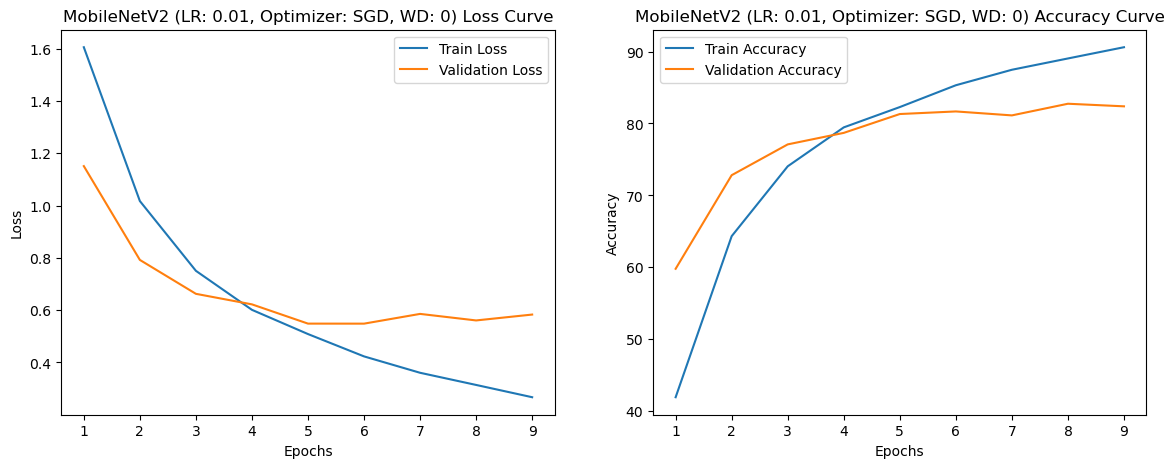


Training MobileNetV2 with SGD optimizer, Learning Rate: 0.01, Weight Decay: 0.0001


Epoch 1/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 1.5935, Train Acc: 42.70%, Val Loss: 1.2164, Val Acc: 56.84%


Epoch 2/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 1.0303, Train Acc: 64.05%, Val Loss: 0.8482, Val Acc: 70.57%


Epoch 3/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.7618, Train Acc: 73.68%, Val Loss: 0.7388, Val Acc: 74.49%


Epoch 4/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 0.6197, Train Acc: 78.68%, Val Loss: 0.6156, Val Acc: 79.24%


Epoch 5/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 0.5153, Train Acc: 82.20%, Val Loss: 0.5654, Val Acc: 81.06%


Epoch 6/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 0.4384, Train Acc: 84.74%, Val Loss: 0.5493, Val Acc: 81.54%


Epoch 7/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.68it/s]


Train Loss: 0.3697, Train Acc: 87.09%, Val Loss: 0.5496, Val Acc: 82.12%


Epoch 8/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.3174, Train Acc: 88.94%, Val Loss: 0.5308, Val Acc: 83.64%


Epoch 9/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 0.2864, Train Acc: 89.94%, Val Loss: 0.5499, Val Acc: 82.63%


Epoch 10/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.2477, Train Acc: 91.35%, Val Loss: 0.5489, Val Acc: 83.16%


Epoch 11/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 0.2135, Train Acc: 92.64%, Val Loss: 0.5539, Val Acc: 83.65%
Early stopping triggered


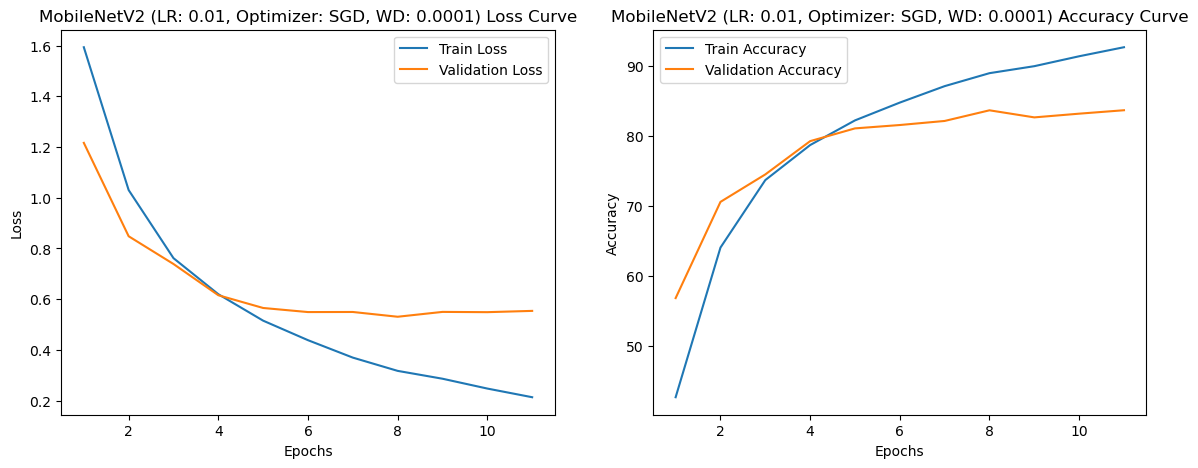


Training MobileNetV2 with SGD optimizer, Learning Rate: 0.01, Weight Decay: 0.001


Epoch 1/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 1.5523, Train Acc: 43.93%, Val Loss: 1.2334, Val Acc: 57.52%


Epoch 2/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.9958, Train Acc: 65.05%, Val Loss: 0.8543, Val Acc: 69.60%


Epoch 3/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.7549, Train Acc: 73.62%, Val Loss: 0.7092, Val Acc: 75.12%


Epoch 4/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.71it/s]


Train Loss: 0.6284, Train Acc: 78.16%, Val Loss: 0.6564, Val Acc: 77.63%


Epoch 5/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 0.5514, Train Acc: 80.85%, Val Loss: 0.6191, Val Acc: 78.83%


Epoch 6/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 0.4985, Train Acc: 82.73%, Val Loss: 0.5738, Val Acc: 80.35%


Epoch 7/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 0.4533, Train Acc: 84.41%, Val Loss: 0.5682, Val Acc: 80.75%


Epoch 8/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 0.4298, Train Acc: 85.20%, Val Loss: 0.5284, Val Acc: 82.16%


Epoch 9/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.68it/s]


Train Loss: 0.4147, Train Acc: 85.44%, Val Loss: 0.5504, Val Acc: 81.40%


Epoch 10/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 0.3973, Train Acc: 86.23%, Val Loss: 0.4798, Val Acc: 83.61%


Epoch 11/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 0.3851, Train Acc: 86.86%, Val Loss: 0.5670, Val Acc: 80.80%


Epoch 12/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 0.3728, Train Acc: 87.20%, Val Loss: 0.4579, Val Acc: 84.51%


Epoch 13/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 0.3689, Train Acc: 87.50%, Val Loss: 0.6189, Val Acc: 79.48%


Epoch 14/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 0.3626, Train Acc: 87.60%, Val Loss: 0.5671, Val Acc: 80.77%


Epoch 15/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 0.3654, Train Acc: 87.39%, Val Loss: 0.5645, Val Acc: 81.02%
Early stopping triggered


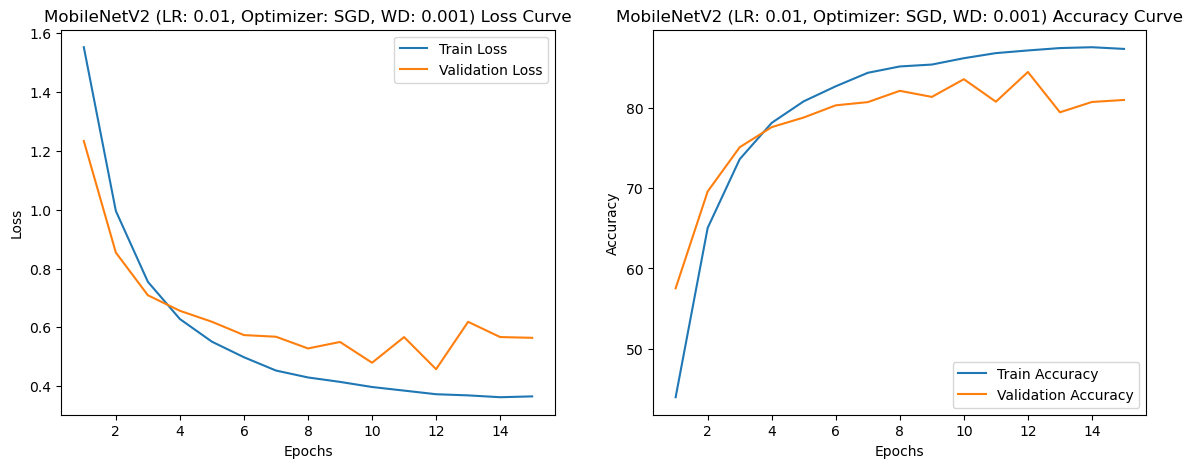


Training MobileNetV2 with ADAM optimizer, Learning Rate: 0.001, Weight Decay: 0


Epoch 1/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 1.4358, Train Acc: 47.49%, Val Loss: 1.0906, Val Acc: 60.81%


Epoch 2/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 1.0025, Train Acc: 64.46%, Val Loss: 0.8922, Val Acc: 68.65%


Epoch 3/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 0.7879, Train Acc: 72.56%, Val Loss: 0.9132, Val Acc: 69.28%


Epoch 4/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.6529, Train Acc: 77.44%, Val Loss: 0.6400, Val Acc: 78.12%


Epoch 5/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.5655, Train Acc: 80.53%, Val Loss: 0.6230, Val Acc: 78.78%


Epoch 6/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.4959, Train Acc: 82.89%, Val Loss: 0.5419, Val Acc: 81.25%


Epoch 7/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.4376, Train Acc: 84.87%, Val Loss: 0.5320, Val Acc: 81.85%


Epoch 8/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 0.3799, Train Acc: 86.76%, Val Loss: 0.5373, Val Acc: 81.59%


Epoch 9/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 0.3330, Train Acc: 88.40%, Val Loss: 0.5114, Val Acc: 83.42%


Epoch 10/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 0.2920, Train Acc: 89.86%, Val Loss: 0.5148, Val Acc: 83.65%


Epoch 11/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 0.2563, Train Acc: 91.00%, Val Loss: 0.4944, Val Acc: 84.57%


Epoch 12/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 0.2222, Train Acc: 92.15%, Val Loss: 0.4971, Val Acc: 84.71%


Epoch 13/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 0.1990, Train Acc: 92.80%, Val Loss: 0.5081, Val Acc: 85.13%


Epoch 14/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 0.1816, Train Acc: 93.61%, Val Loss: 0.5269, Val Acc: 84.56%
Early stopping triggered


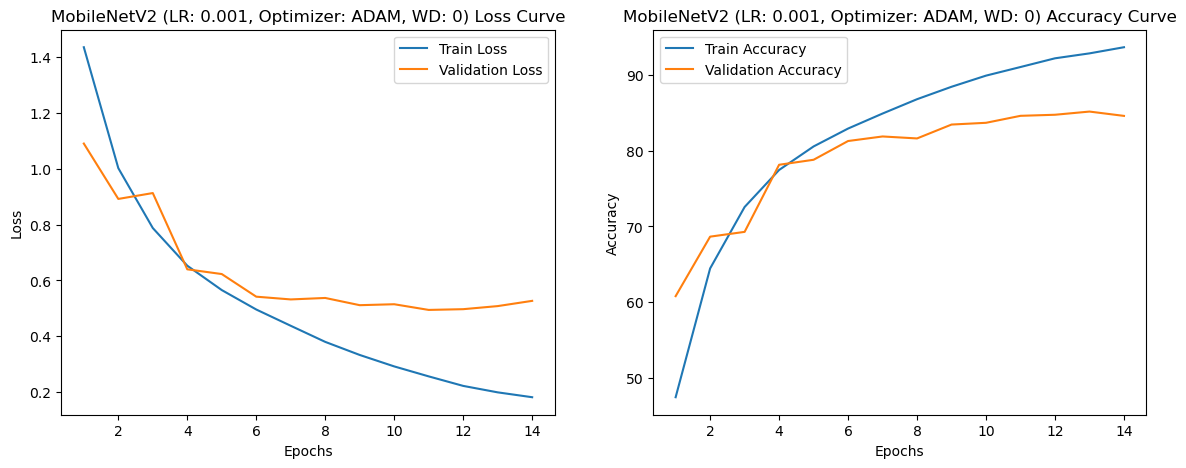


Training MobileNetV2 with ADAM optimizer, Learning Rate: 0.001, Weight Decay: 0.0001


Epoch 1/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 1.4480, Train Acc: 47.15%, Val Loss: 1.3363, Val Acc: 54.21%


Epoch 2/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 1.0073, Train Acc: 64.45%, Val Loss: 0.8728, Val Acc: 69.36%


Epoch 3/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 0.8004, Train Acc: 72.16%, Val Loss: 0.8040, Val Acc: 72.65%


Epoch 4/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.6923, Train Acc: 76.09%, Val Loss: 0.6450, Val Acc: 78.02%


Epoch 5/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.69it/s]


Train Loss: 0.6183, Train Acc: 78.75%, Val Loss: 0.7213, Val Acc: 76.09%


Epoch 6/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 0.5644, Train Acc: 80.60%, Val Loss: 0.6138, Val Acc: 78.77%


Epoch 7/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 0.5189, Train Acc: 82.09%, Val Loss: 0.5340, Val Acc: 82.04%


Epoch 8/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 0.4763, Train Acc: 83.62%, Val Loss: 0.5369, Val Acc: 81.83%


Epoch 9/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.4406, Train Acc: 84.90%, Val Loss: 0.5165, Val Acc: 82.46%


Epoch 10/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 0.4162, Train Acc: 85.55%, Val Loss: 0.5056, Val Acc: 82.73%


Epoch 11/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 0.3899, Train Acc: 86.59%, Val Loss: 0.5175, Val Acc: 82.32%


Epoch 12/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.68it/s]


Train Loss: 0.3669, Train Acc: 87.29%, Val Loss: 0.4881, Val Acc: 83.98%


Epoch 13/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.3526, Train Acc: 87.67%, Val Loss: 0.5114, Val Acc: 83.15%


Epoch 14/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.3295, Train Acc: 88.44%, Val Loss: 0.5011, Val Acc: 83.72%


Epoch 15/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.62it/s]


Train Loss: 0.3124, Train Acc: 89.18%, Val Loss: 0.4797, Val Acc: 84.35%


Epoch 16/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.3057, Train Acc: 89.44%, Val Loss: 0.5042, Val Acc: 83.91%


Epoch 17/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 0.2906, Train Acc: 89.82%, Val Loss: 0.4429, Val Acc: 85.88%


Epoch 18/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.68it/s]


Train Loss: 0.2749, Train Acc: 90.53%, Val Loss: 0.4885, Val Acc: 84.06%


Epoch 19/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.2669, Train Acc: 90.73%, Val Loss: 0.4864, Val Acc: 84.24%


Epoch 20/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 0.2603, Train Acc: 90.88%, Val Loss: 0.4780, Val Acc: 84.85%
Early stopping triggered


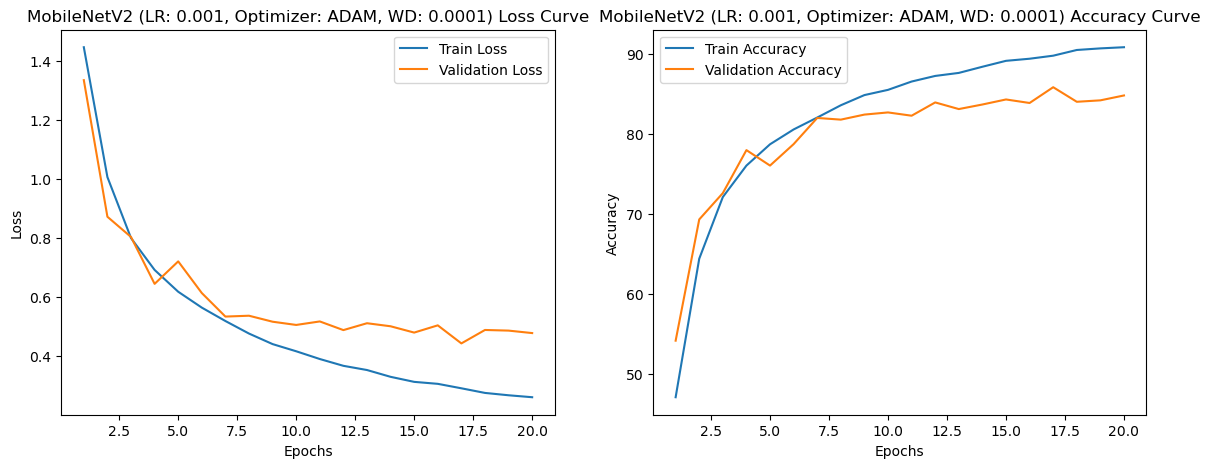


Training MobileNetV2 with ADAM optimizer, Learning Rate: 0.001, Weight Decay: 0.001


Epoch 1/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.68it/s]


Train Loss: 1.5356, Train Acc: 43.18%, Val Loss: 1.5055, Val Acc: 45.31%


Epoch 2/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.70it/s]


Train Loss: 1.1459, Train Acc: 58.59%, Val Loss: 1.0893, Val Acc: 61.27%


Epoch 3/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.70it/s]


Train Loss: 0.9628, Train Acc: 66.05%, Val Loss: 1.0470, Val Acc: 63.12%


Epoch 4/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.68it/s]


Train Loss: 0.8561, Train Acc: 70.09%, Val Loss: 0.8270, Val Acc: 71.16%


Epoch 5/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.68it/s]


Train Loss: 0.7766, Train Acc: 72.92%, Val Loss: 0.7353, Val Acc: 74.51%


Epoch 6/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.68it/s]


Train Loss: 0.7158, Train Acc: 75.01%, Val Loss: 0.6917, Val Acc: 76.54%


Epoch 7/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 0.6804, Train Acc: 76.50%, Val Loss: 0.6638, Val Acc: 76.74%


Epoch 8/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 0.6538, Train Acc: 77.50%, Val Loss: 0.6508, Val Acc: 77.31%


Epoch 9/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.6264, Train Acc: 78.36%, Val Loss: 0.6723, Val Acc: 77.03%


Epoch 10/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 0.6072, Train Acc: 79.30%, Val Loss: 0.6317, Val Acc: 78.59%


Epoch 11/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.68it/s]


Train Loss: 0.5876, Train Acc: 79.75%, Val Loss: 0.6105, Val Acc: 79.01%


Epoch 12/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.5763, Train Acc: 80.24%, Val Loss: 0.5871, Val Acc: 80.05%


Epoch 13/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 0.5627, Train Acc: 80.70%, Val Loss: 0.5788, Val Acc: 80.25%


Epoch 14/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 0.5514, Train Acc: 81.15%, Val Loss: 0.5644, Val Acc: 80.85%


Epoch 15/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.69it/s]


Train Loss: 0.5356, Train Acc: 81.87%, Val Loss: 0.6425, Val Acc: 77.80%


Epoch 16/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 0.5284, Train Acc: 81.99%, Val Loss: 0.6125, Val Acc: 79.25%


Epoch 17/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.5115, Train Acc: 82.52%, Val Loss: 0.5422, Val Acc: 81.88%


Epoch 18/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 0.5061, Train Acc: 82.89%, Val Loss: 0.5193, Val Acc: 82.33%


Epoch 19/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.70it/s]


Train Loss: 0.4999, Train Acc: 83.06%, Val Loss: 0.5293, Val Acc: 82.12%


Epoch 20/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.69it/s]


Train Loss: 0.4901, Train Acc: 83.23%, Val Loss: 0.5529, Val Acc: 80.97%


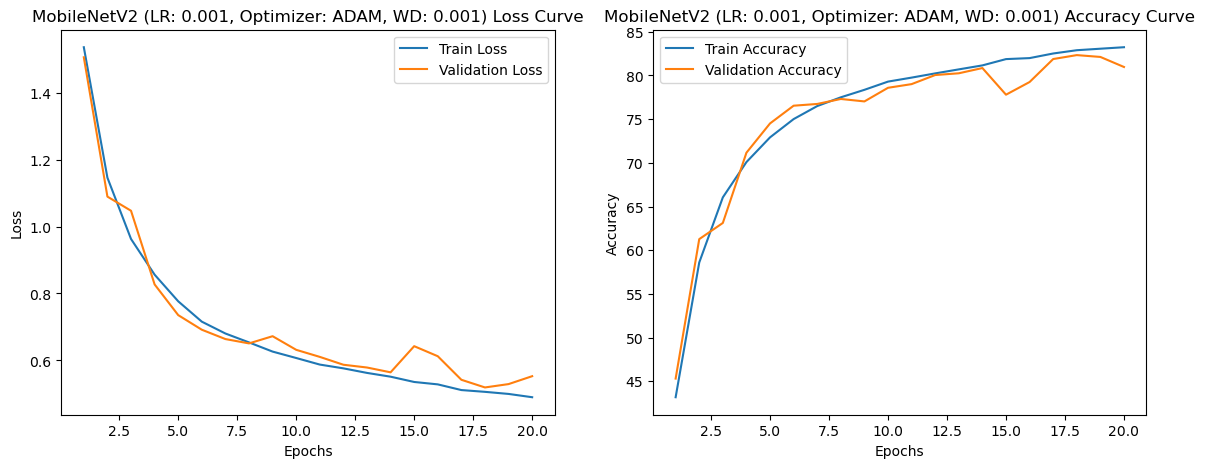


Training MobileNetV2 with SGD optimizer, Learning Rate: 0.001, Weight Decay: 0


Epoch 1/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 1.7505, Train Acc: 32.80%, Val Loss: 1.4568, Val Acc: 46.22%


Epoch 2/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 1.3557, Train Acc: 50.43%, Val Loss: 1.1859, Val Acc: 56.85%


Epoch 3/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.62it/s]


Train Loss: 1.1383, Train Acc: 58.89%, Val Loss: 1.0216, Val Acc: 63.64%


Epoch 4/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.69it/s]


Train Loss: 0.9663, Train Acc: 65.82%, Val Loss: 0.9372, Val Acc: 66.89%


Epoch 5/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.8561, Train Acc: 69.84%, Val Loss: 0.8125, Val Acc: 71.14%


Epoch 6/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.7541, Train Acc: 73.27%, Val Loss: 0.7723, Val Acc: 73.01%


Epoch 7/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 0.6739, Train Acc: 76.24%, Val Loss: 0.7348, Val Acc: 74.91%


Epoch 8/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 0.5954, Train Acc: 79.26%, Val Loss: 0.7005, Val Acc: 75.90%


Epoch 9/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.69it/s]


Train Loss: 0.5260, Train Acc: 81.72%, Val Loss: 0.6551, Val Acc: 77.81%


Epoch 10/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.4737, Train Acc: 83.26%, Val Loss: 0.6571, Val Acc: 78.00%


Epoch 11/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 0.4181, Train Acc: 85.43%, Val Loss: 0.6521, Val Acc: 78.44%


Epoch 12/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 0.3678, Train Acc: 86.97%, Val Loss: 0.6518, Val Acc: 78.86%


Epoch 13/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 0.3269, Train Acc: 88.46%, Val Loss: 0.6562, Val Acc: 79.58%


Epoch 14/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 0.2841, Train Acc: 90.01%, Val Loss: 0.6909, Val Acc: 79.35%


Epoch 15/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.68it/s]


Train Loss: 0.2532, Train Acc: 91.08%, Val Loss: 0.6896, Val Acc: 79.26%
Early stopping triggered


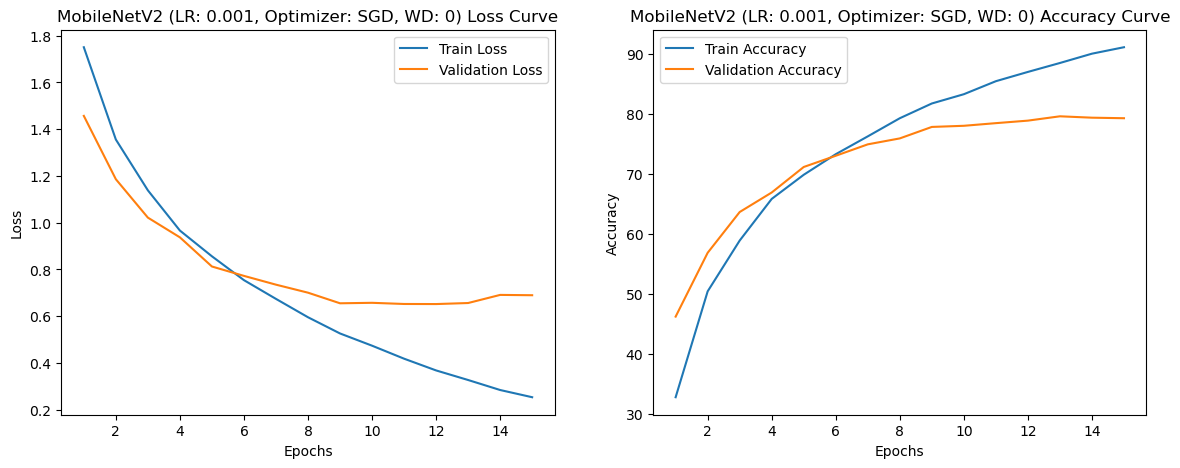


Training MobileNetV2 with SGD optimizer, Learning Rate: 0.001, Weight Decay: 0.0001


Epoch 1/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.74it/s]


Train Loss: 1.7609, Train Acc: 32.58%, Val Loss: 1.5411, Val Acc: 42.27%


Epoch 2/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.70it/s]


Train Loss: 1.3915, Train Acc: 49.07%, Val Loss: 1.2662, Val Acc: 54.84%


Epoch 3/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.73it/s]


Train Loss: 1.1610, Train Acc: 58.54%, Val Loss: 1.0433, Val Acc: 63.18%


Epoch 4/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.73it/s]


Train Loss: 0.9963, Train Acc: 64.88%, Val Loss: 0.9161, Val Acc: 67.83%


Epoch 5/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.73it/s]


Train Loss: 0.8725, Train Acc: 69.39%, Val Loss: 0.8585, Val Acc: 69.81%


Epoch 6/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.72it/s]


Train Loss: 0.7640, Train Acc: 73.06%, Val Loss: 0.7667, Val Acc: 73.39%


Epoch 7/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.75it/s]


Train Loss: 0.6795, Train Acc: 76.29%, Val Loss: 0.7010, Val Acc: 75.59%


Epoch 8/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.71it/s]


Train Loss: 0.6024, Train Acc: 78.99%, Val Loss: 0.6722, Val Acc: 77.06%


Epoch 9/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.71it/s]


Train Loss: 0.5316, Train Acc: 81.40%, Val Loss: 0.6318, Val Acc: 78.69%


Epoch 10/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.73it/s]


Train Loss: 0.4713, Train Acc: 83.47%, Val Loss: 0.6810, Val Acc: 77.08%


Epoch 11/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.74it/s]


Train Loss: 0.4165, Train Acc: 85.51%, Val Loss: 0.6238, Val Acc: 79.07%


Epoch 12/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.76it/s]


Train Loss: 0.3742, Train Acc: 86.91%, Val Loss: 0.6282, Val Acc: 78.99%


Epoch 13/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.72it/s]


Train Loss: 0.3287, Train Acc: 88.52%, Val Loss: 0.6310, Val Acc: 79.84%


Epoch 14/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.72it/s]


Train Loss: 0.2881, Train Acc: 89.84%, Val Loss: 0.6519, Val Acc: 79.72%
Early stopping triggered


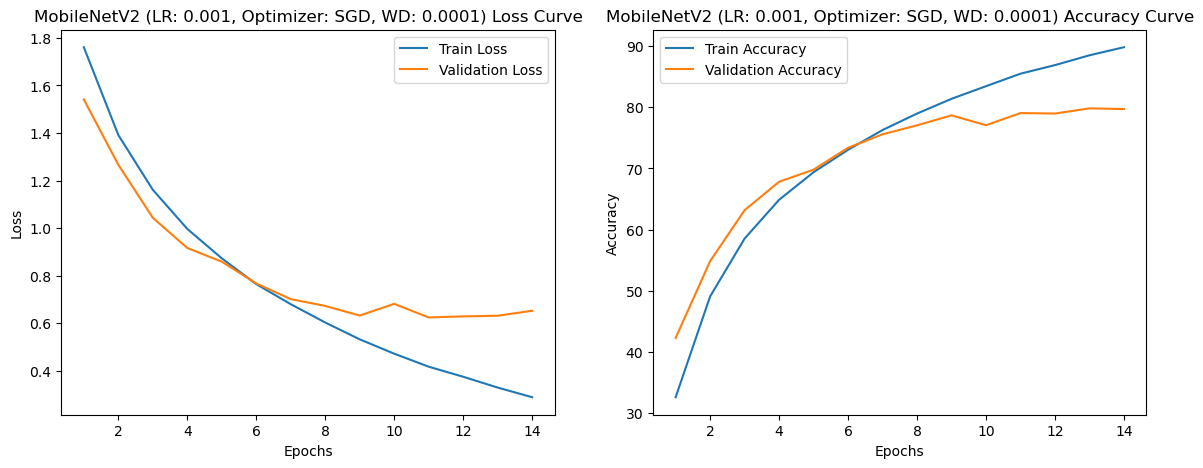


Training MobileNetV2 with SGD optimizer, Learning Rate: 0.001, Weight Decay: 0.001


Epoch 1/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 1.7475, Train Acc: 33.58%, Val Loss: 1.4608, Val Acc: 44.60%


Epoch 2/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 1.3728, Train Acc: 49.74%, Val Loss: 1.2758, Val Acc: 53.86%


Epoch 3/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 1.1505, Train Acc: 58.65%, Val Loss: 1.0558, Val Acc: 62.64%


Epoch 4/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 0.9957, Train Acc: 64.80%, Val Loss: 0.9178, Val Acc: 67.06%


Epoch 5/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 0.8821, Train Acc: 68.95%, Val Loss: 0.8473, Val Acc: 70.28%


Epoch 6/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.7731, Train Acc: 72.88%, Val Loss: 0.7420, Val Acc: 73.40%


Epoch 7/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.6779, Train Acc: 76.25%, Val Loss: 0.7201, Val Acc: 75.03%


Epoch 8/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.6029, Train Acc: 78.81%, Val Loss: 0.6474, Val Acc: 77.11%


Epoch 9/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.63it/s]


Train Loss: 0.5301, Train Acc: 81.45%, Val Loss: 0.6574, Val Acc: 77.38%


Epoch 10/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.4778, Train Acc: 83.41%, Val Loss: 0.6209, Val Acc: 78.69%


Epoch 11/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.4235, Train Acc: 84.91%, Val Loss: 0.6168, Val Acc: 79.10%


Epoch 12/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.66it/s]


Train Loss: 0.3734, Train Acc: 87.14%, Val Loss: 0.6443, Val Acc: 78.66%


Epoch 13/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.65it/s]


Train Loss: 0.3366, Train Acc: 88.30%, Val Loss: 0.5961, Val Acc: 80.07%


Epoch 14/20: 100%|██████████| 1250/1250 [01:20<00:00, 15.59it/s]


Train Loss: 0.2942, Train Acc: 89.69%, Val Loss: 0.5980, Val Acc: 80.62%


Epoch 15/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.64it/s]


Train Loss: 0.2694, Train Acc: 90.37%, Val Loss: 0.6130, Val Acc: 80.50%


Epoch 16/20: 100%|██████████| 1250/1250 [01:19<00:00, 15.67it/s]


Train Loss: 0.2364, Train Acc: 91.79%, Val Loss: 0.6223, Val Acc: 80.79%
Early stopping triggered


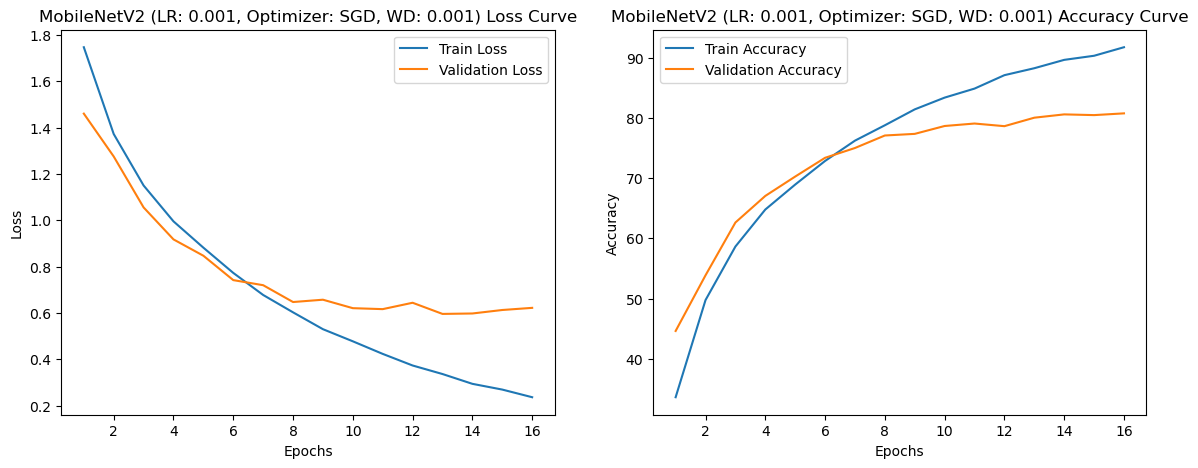


Best configuration for MobileNetV2 - Optimizer: ADAM, Learning Rate: 0.001, Weight Decay: 0.0001, Validation Accuracy: 85.88%

Training VGG11 with ADAM optimizer, Learning Rate: 0.1, Weight Decay: 0


Epoch 1/20: 100%|██████████| 1250/1250 [01:48<00:00, 11.56it/s]


Train Loss: 1866862954519736.0000, Train Acc: 10.28%, Val Loss: 2.3106, Val Acc: 9.75%


Epoch 2/20: 100%|██████████| 1250/1250 [01:47<00:00, 11.57it/s]


Train Loss: 2.3136, Train Acc: 9.92%, Val Loss: 2.3088, Val Acc: 9.95%


Epoch 3/20: 100%|██████████| 1250/1250 [01:48<00:00, 11.57it/s]


Train Loss: 2.3156, Train Acc: 10.04%, Val Loss: 2.3073, Val Acc: 9.81%


Epoch 4/20: 100%|██████████| 1250/1250 [01:48<00:00, 11.56it/s]


Train Loss: 2.3147, Train Acc: 10.22%, Val Loss: 2.3188, Val Acc: 10.40%


Epoch 5/20: 100%|██████████| 1250/1250 [01:48<00:00, 11.57it/s]


Train Loss: 2.3141, Train Acc: 10.16%, Val Loss: 2.3245, Val Acc: 9.40%


Epoch 6/20: 100%|██████████| 1250/1250 [01:48<00:00, 11.57it/s]


Train Loss: 2.3153, Train Acc: 9.90%, Val Loss: 2.3114, Val Acc: 9.95%
Early stopping triggered


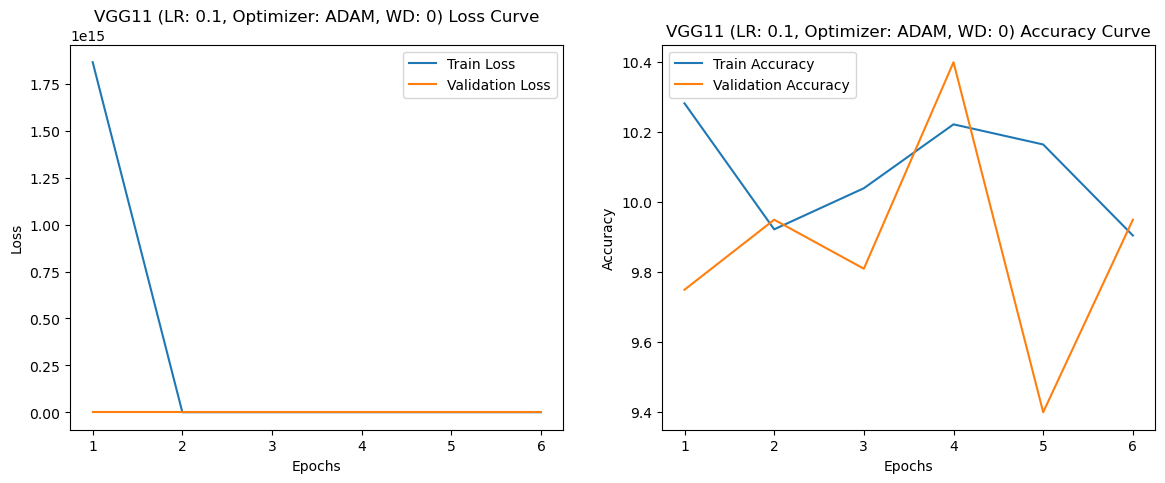


Training VGG11 with ADAM optimizer, Learning Rate: 0.1, Weight Decay: 0.0001


Epoch 1/20: 100%|██████████| 1250/1250 [01:50<00:00, 11.35it/s]


Train Loss: 3032436641312953.0000, Train Acc: 10.04%, Val Loss: 2.3385, Val Acc: 9.75%


Epoch 2/20: 100%|██████████| 1250/1250 [01:50<00:00, 11.35it/s]


Train Loss: 125194117.8109, Train Acc: 10.14%, Val Loss: 2.3078, Val Acc: 10.40%


Epoch 3/20: 100%|██████████| 1250/1250 [01:49<00:00, 11.37it/s]


Train Loss: 2.3408, Train Acc: 9.66%, Val Loss: 2.3172, Val Acc: 9.86%


Epoch 4/20: 100%|██████████| 1250/1250 [01:50<00:00, 11.34it/s]


Train Loss: 2.3198, Train Acc: 9.89%, Val Loss: 2.3176, Val Acc: 9.95%


Epoch 5/20: 100%|██████████| 1250/1250 [01:50<00:00, 11.35it/s]


Train Loss: 2.3382, Train Acc: 10.02%, Val Loss: 2.3307, Val Acc: 10.37%
Early stopping triggered


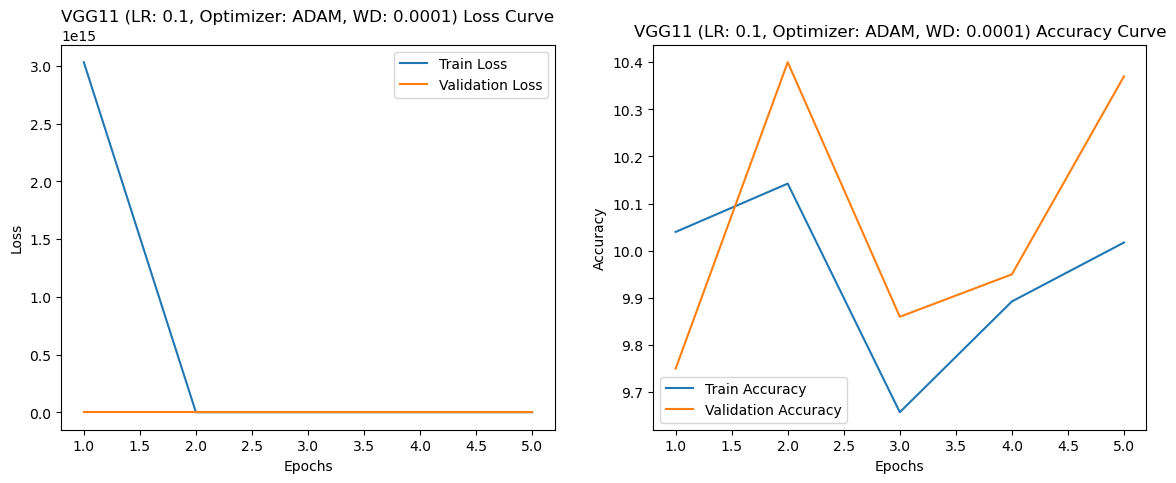


Training VGG11 with ADAM optimizer, Learning Rate: 0.1, Weight Decay: 0.001


Epoch 1/20: 100%|██████████| 1250/1250 [01:50<00:00, 11.32it/s]


Train Loss: 252324508632531.4062, Train Acc: 9.87%, Val Loss: 2.3594, Val Acc: 10.37%


Epoch 2/20: 100%|██████████| 1250/1250 [01:50<00:00, 11.34it/s]


Train Loss: 3507.1216, Train Acc: 9.71%, Val Loss: 2.3224, Val Acc: 10.37%


Epoch 3/20: 100%|██████████| 1250/1250 [01:50<00:00, 11.32it/s]


Train Loss: 2.4037, Train Acc: 10.01%, Val Loss: 2.4425, Val Acc: 9.81%


Epoch 4/20: 100%|██████████| 1250/1250 [01:50<00:00, 11.33it/s]


Train Loss: 2.4337, Train Acc: 10.03%, Val Loss: 2.4094, Val Acc: 10.74%


Epoch 5/20: 100%|██████████| 1250/1250 [01:50<00:00, 11.33it/s]


Train Loss: 2.4378, Train Acc: 9.91%, Val Loss: 2.3394, Val Acc: 9.95%
Early stopping triggered


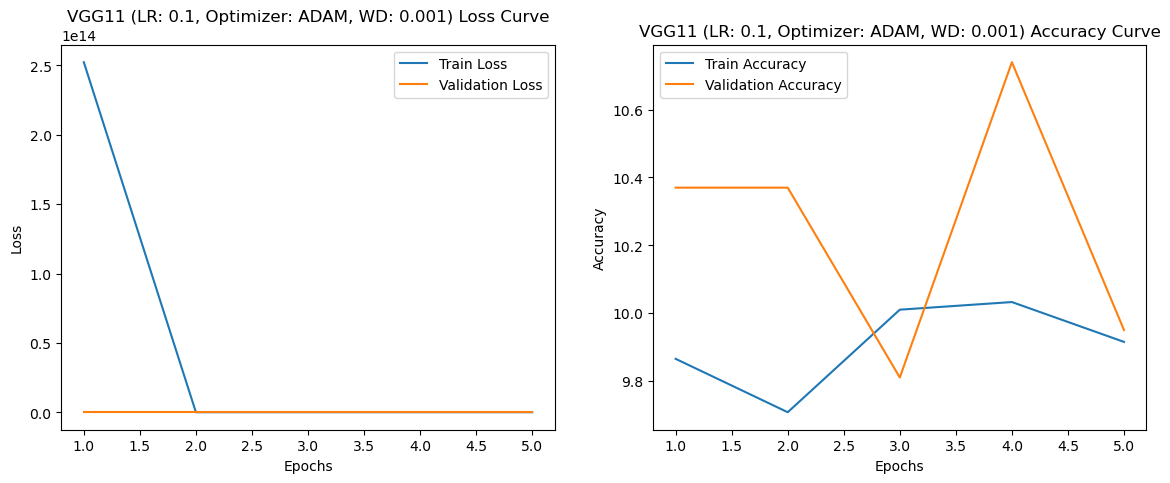


Training VGG11 with SGD optimizer, Learning Rate: 0.1, Weight Decay: 0


Epoch 1/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.37it/s]


Train Loss: 2.3111, Train Acc: 10.20%, Val Loss: 2.3187, Val Acc: 9.40%


Epoch 2/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.36it/s]


Train Loss: 2.3097, Train Acc: 9.99%, Val Loss: 2.3097, Val Acc: 10.74%


Epoch 3/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.36it/s]


Train Loss: 2.3097, Train Acc: 10.07%, Val Loss: 2.3094, Val Acc: 9.75%


Epoch 4/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.37it/s]


Train Loss: 2.3098, Train Acc: 10.04%, Val Loss: 2.3125, Val Acc: 9.95%


Epoch 5/20: 100%|██████████| 1250/1250 [01:40<00:00, 12.39it/s]


Train Loss: 2.3090, Train Acc: 10.14%, Val Loss: 2.3227, Val Acc: 9.71%


Epoch 6/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.36it/s]


Train Loss: 2.3098, Train Acc: 9.95%, Val Loss: 2.3084, Val Acc: 9.95%


Epoch 7/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.37it/s]


Train Loss: 2.3093, Train Acc: 10.21%, Val Loss: 2.3111, Val Acc: 10.01%


Epoch 8/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.37it/s]


Train Loss: 2.3096, Train Acc: 10.02%, Val Loss: 2.3136, Val Acc: 10.01%


Epoch 9/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.37it/s]


Train Loss: 2.3097, Train Acc: 10.09%, Val Loss: 2.3073, Val Acc: 9.75%


Epoch 10/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.37it/s]


Train Loss: 2.3098, Train Acc: 10.00%, Val Loss: 2.3099, Val Acc: 9.81%


Epoch 11/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.37it/s]


Train Loss: 2.3100, Train Acc: 9.88%, Val Loss: 2.3047, Val Acc: 10.01%


Epoch 12/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.37it/s]


Train Loss: 2.3096, Train Acc: 10.18%, Val Loss: 2.3176, Val Acc: 9.86%


Epoch 13/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.37it/s]


Train Loss: 2.3096, Train Acc: 9.89%, Val Loss: 2.3089, Val Acc: 9.71%


Epoch 14/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.38it/s]


Train Loss: 2.3100, Train Acc: 9.95%, Val Loss: 2.3052, Val Acc: 10.40%
Early stopping triggered


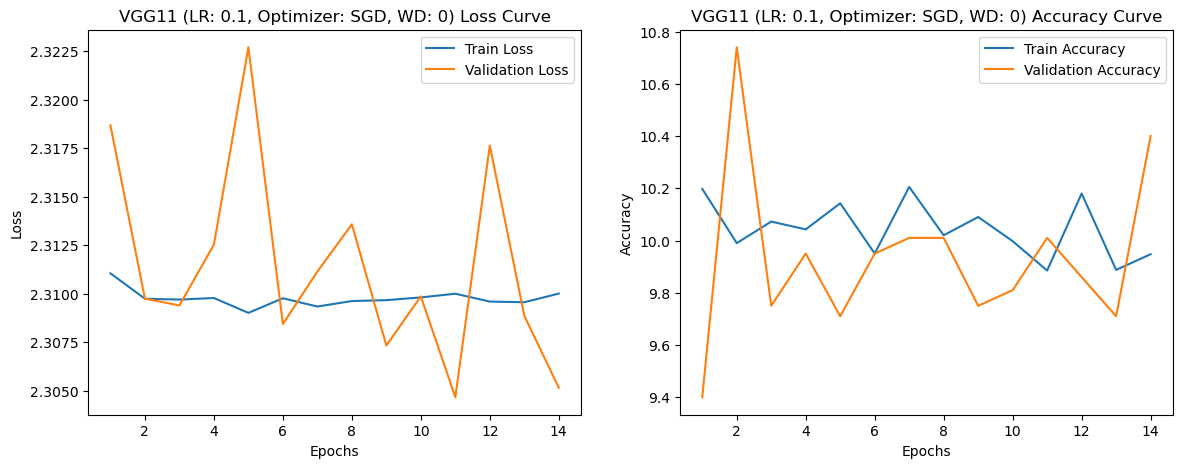


Training VGG11 with SGD optimizer, Learning Rate: 0.1, Weight Decay: 0.0001


Epoch 1/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.10it/s]


Train Loss: 2.3098, Train Acc: 9.98%, Val Loss: 2.3064, Val Acc: 9.75%


Epoch 2/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.12it/s]


Train Loss: 2.3098, Train Acc: 9.80%, Val Loss: 2.3175, Val Acc: 9.81%


Epoch 3/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.12it/s]


Train Loss: 2.3104, Train Acc: 10.01%, Val Loss: 2.3150, Val Acc: 10.40%


Epoch 4/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.11it/s]


Train Loss: 2.3097, Train Acc: 9.96%, Val Loss: 2.3044, Val Acc: 9.95%


Epoch 5/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.11it/s]


Train Loss: 2.3093, Train Acc: 10.00%, Val Loss: 2.3056, Val Acc: 9.81%


Epoch 6/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.12it/s]


Train Loss: 2.3098, Train Acc: 10.02%, Val Loss: 2.3149, Val Acc: 9.86%


Epoch 7/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.12it/s]


Train Loss: 2.3096, Train Acc: 9.99%, Val Loss: 2.3115, Val Acc: 9.95%
Early stopping triggered


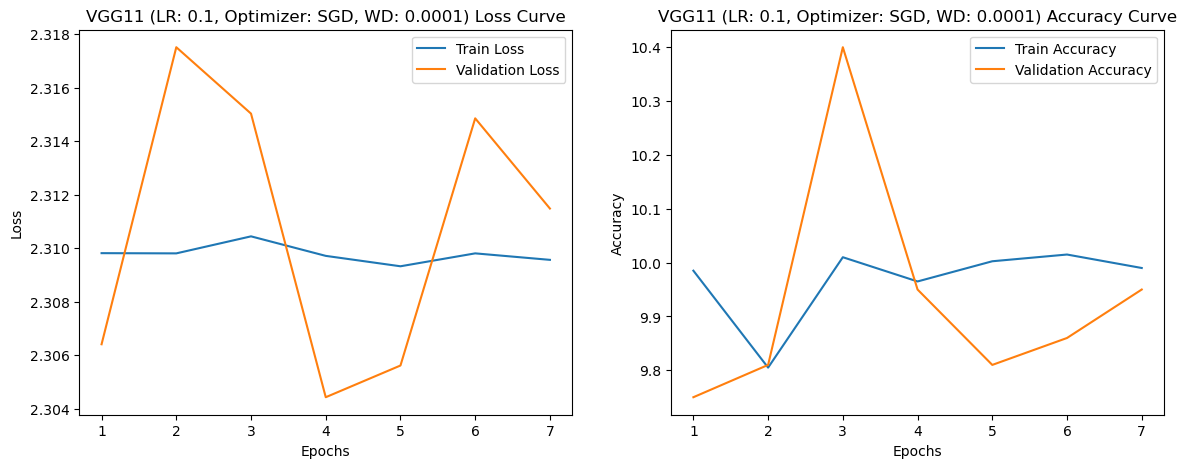


Training VGG11 with SGD optimizer, Learning Rate: 0.1, Weight Decay: 0.001


Epoch 1/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.10it/s]


Train Loss: 2.3097, Train Acc: 10.01%, Val Loss: 2.3110, Val Acc: 9.71%


Epoch 2/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.11it/s]


Train Loss: 2.3099, Train Acc: 9.96%, Val Loss: 2.3041, Val Acc: 9.86%


Epoch 3/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.11it/s]


Train Loss: 2.3094, Train Acc: 10.20%, Val Loss: 2.3117, Val Acc: 9.81%


Epoch 4/20: 100%|██████████| 1250/1250 [01:47<00:00, 11.67it/s]


Train Loss: 2.3096, Train Acc: 9.67%, Val Loss: 2.3093, Val Acc: 9.71%


Epoch 5/20: 100%|██████████| 1250/1250 [01:57<00:00, 10.61it/s]


Train Loss: 2.3099, Train Acc: 9.87%, Val Loss: 2.3079, Val Acc: 10.74%
Early stopping triggered


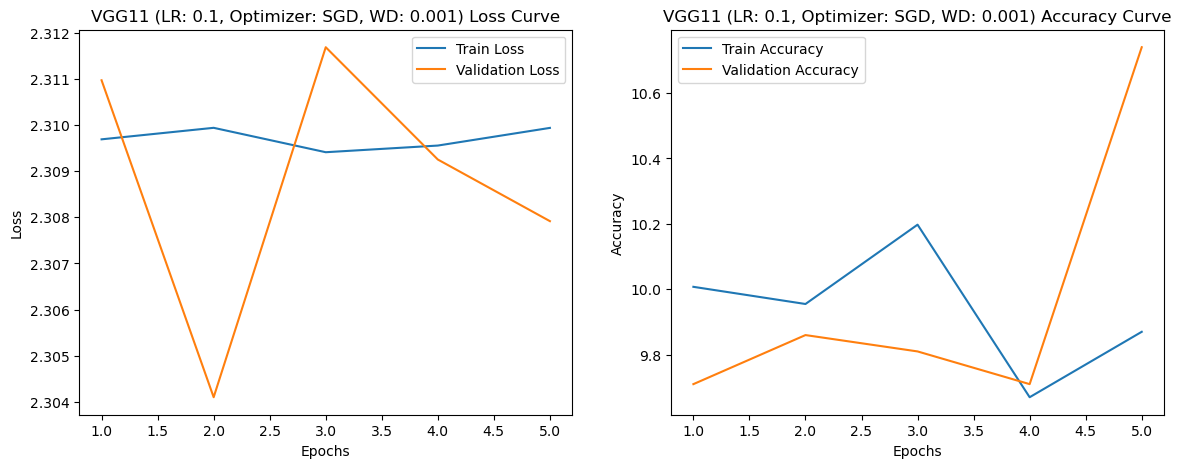


Training VGG11 with ADAM optimizer, Learning Rate: 0.01, Weight Decay: 0


Epoch 1/20: 100%|██████████| 1250/1250 [02:04<00:00, 10.05it/s]


Train Loss: 103056.1606, Train Acc: 9.99%, Val Loss: 2.3034, Val Acc: 10.74%


Epoch 2/20: 100%|██████████| 1250/1250 [02:17<00:00,  9.11it/s]


Train Loss: 2.3039, Train Acc: 9.79%, Val Loss: 2.3032, Val Acc: 9.86%


Epoch 3/20: 100%|██████████| 1250/1250 [02:17<00:00,  9.10it/s]


Train Loss: 2.3042, Train Acc: 9.68%, Val Loss: 2.3030, Val Acc: 9.95%


Epoch 4/20: 100%|██████████| 1250/1250 [02:19<00:00,  8.95it/s]


Train Loss: 2.3039, Train Acc: 9.94%, Val Loss: 2.3048, Val Acc: 9.40%


Epoch 5/20: 100%|██████████| 1250/1250 [02:20<00:00,  8.90it/s]


Train Loss: 2.3040, Train Acc: 9.77%, Val Loss: 2.3060, Val Acc: 9.71%


Epoch 6/20: 100%|██████████| 1250/1250 [02:21<00:00,  8.86it/s]


Train Loss: 2.3039, Train Acc: 10.05%, Val Loss: 2.3025, Val Acc: 10.40%


Epoch 7/20: 100%|██████████| 1250/1250 [02:17<00:00,  9.12it/s]


Train Loss: 2.3037, Train Acc: 10.02%, Val Loss: 2.3031, Val Acc: 9.40%


Epoch 8/20: 100%|██████████| 1250/1250 [02:16<00:00,  9.13it/s]


Train Loss: 2.3039, Train Acc: 10.05%, Val Loss: 2.3039, Val Acc: 10.01%


Epoch 9/20: 100%|██████████| 1250/1250 [02:19<00:00,  8.97it/s]


Train Loss: 2.3038, Train Acc: 9.97%, Val Loss: 2.3033, Val Acc: 9.95%
Early stopping triggered


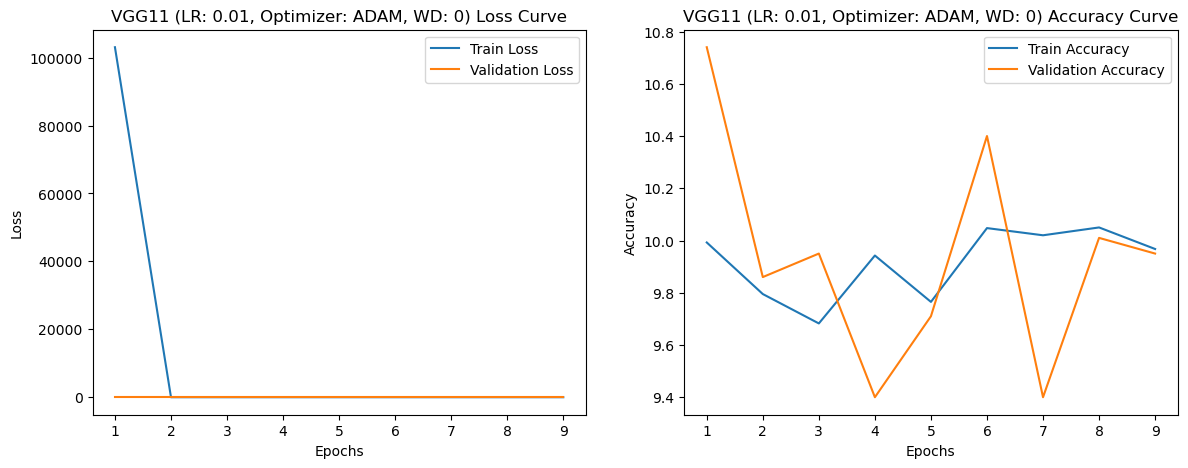


Training VGG11 with ADAM optimizer, Learning Rate: 0.01, Weight Decay: 0.0001


Epoch 1/20: 100%|██████████| 1250/1250 [02:32<00:00,  8.19it/s]


Train Loss: 153701.4393, Train Acc: 9.94%, Val Loss: 3.0948, Val Acc: 9.75%


Epoch 2/20: 100%|██████████| 1250/1250 [02:24<00:00,  8.62it/s]


Train Loss: 7666.0088, Train Acc: 10.13%, Val Loss: 2.3037, Val Acc: 9.81%


Epoch 3/20: 100%|██████████| 1250/1250 [02:23<00:00,  8.73it/s]


Train Loss: 8566.8018, Train Acc: 10.16%, Val Loss: 2.3063, Val Acc: 9.95%


Epoch 4/20: 100%|██████████| 1250/1250 [02:24<00:00,  8.67it/s]


Train Loss: 2.3064, Train Acc: 9.90%, Val Loss: 2.3051, Val Acc: 9.40%


Epoch 5/20: 100%|██████████| 1250/1250 [02:21<00:00,  8.82it/s]


Train Loss: 268709324.9083, Train Acc: 9.87%, Val Loss: 2.3041, Val Acc: 10.37%
Early stopping triggered


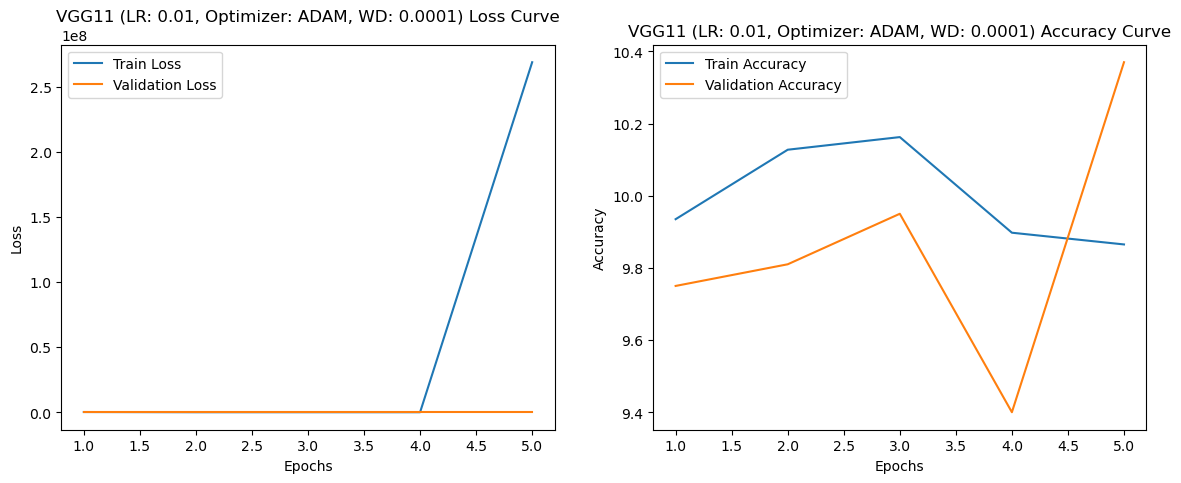


Training VGG11 with ADAM optimizer, Learning Rate: 0.01, Weight Decay: 0.001


Epoch 1/20: 100%|██████████| 1250/1250 [02:22<00:00,  8.75it/s]


Train Loss: 102276.4812, Train Acc: 9.77%, Val Loss: 2.3112, Val Acc: 10.01%


Epoch 2/20: 100%|██████████| 1250/1250 [02:23<00:00,  8.71it/s]


Train Loss: 1781.8978, Train Acc: 9.94%, Val Loss: 2.3029, Val Acc: 10.37%


Epoch 3/20: 100%|██████████| 1250/1250 [02:22<00:00,  8.79it/s]


Train Loss: 2.6786, Train Acc: 10.00%, Val Loss: 2.3048, Val Acc: 10.01%


Epoch 4/20: 100%|██████████| 1250/1250 [02:23<00:00,  8.74it/s]


Train Loss: 40.4414, Train Acc: 10.07%, Val Loss: 2.3038, Val Acc: 9.40%


Epoch 5/20: 100%|██████████| 1250/1250 [01:58<00:00, 10.54it/s]


Train Loss: 5029.1131, Train Acc: 10.13%, Val Loss: 2.3048, Val Acc: 9.71%
Early stopping triggered


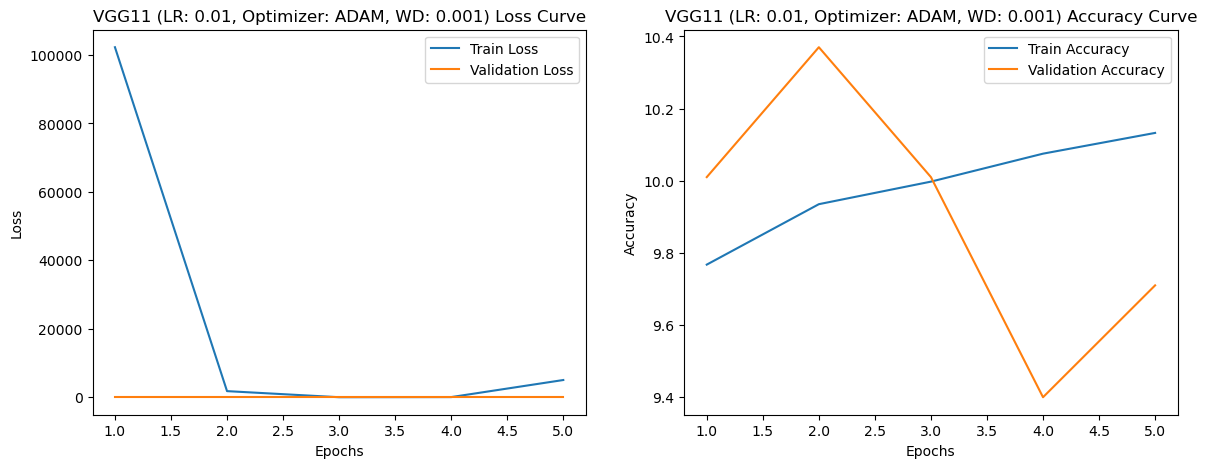


Training VGG11 with SGD optimizer, Learning Rate: 0.01, Weight Decay: 0


Epoch 1/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.06it/s]


Train Loss: 1.6814, Train Acc: 38.47%, Val Loss: 1.2739, Val Acc: 53.91%


Epoch 2/20: 100%|██████████| 1250/1250 [01:44<00:00, 12.01it/s]


Train Loss: 1.1269, Train Acc: 60.05%, Val Loss: 0.9569, Val Acc: 66.19%


Epoch 3/20: 100%|██████████| 1250/1250 [01:44<00:00, 12.02it/s]


Train Loss: 0.8294, Train Acc: 70.96%, Val Loss: 0.7543, Val Acc: 73.75%


Epoch 4/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.11it/s]


Train Loss: 0.6342, Train Acc: 78.02%, Val Loss: 0.7400, Val Acc: 74.74%


Epoch 5/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.33it/s]


Train Loss: 0.4722, Train Acc: 83.50%, Val Loss: 0.7290, Val Acc: 75.76%


Epoch 6/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.35it/s]


Train Loss: 0.3492, Train Acc: 88.10%, Val Loss: 0.7391, Val Acc: 76.95%


Epoch 7/20: 100%|██████████| 1250/1250 [01:42<00:00, 12.24it/s]


Train Loss: 0.2542, Train Acc: 91.34%, Val Loss: 0.7777, Val Acc: 76.21%


Epoch 8/20: 100%|██████████| 1250/1250 [01:42<00:00, 12.16it/s]


Train Loss: 0.2061, Train Acc: 93.03%, Val Loss: 0.8403, Val Acc: 76.79%
Early stopping triggered


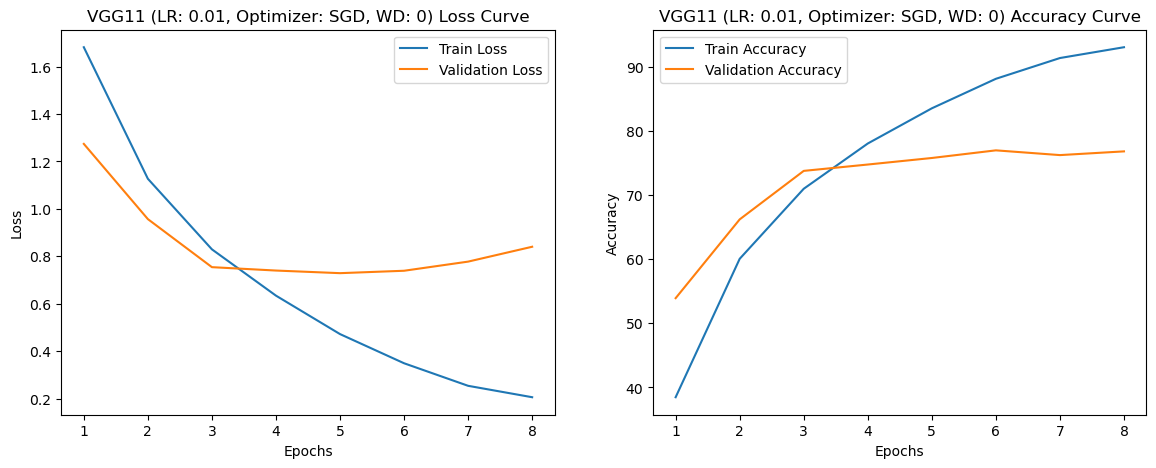


Training VGG11 with SGD optimizer, Learning Rate: 0.01, Weight Decay: 0.0001


Epoch 1/20: 100%|██████████| 1250/1250 [01:45<00:00, 11.86it/s]


Train Loss: 1.6744, Train Acc: 38.20%, Val Loss: 1.3453, Val Acc: 51.11%


Epoch 2/20: 100%|██████████| 1250/1250 [01:44<00:00, 11.92it/s]


Train Loss: 1.1508, Train Acc: 59.34%, Val Loss: 0.9541, Val Acc: 65.73%


Epoch 3/20: 100%|██████████| 1250/1250 [01:44<00:00, 11.91it/s]


Train Loss: 0.8401, Train Acc: 70.54%, Val Loss: 0.7731, Val Acc: 72.71%


Epoch 4/20: 100%|██████████| 1250/1250 [01:44<00:00, 11.91it/s]


Train Loss: 0.6472, Train Acc: 77.62%, Val Loss: 0.8134, Val Acc: 73.55%


Epoch 5/20: 100%|██████████| 1250/1250 [01:44<00:00, 11.91it/s]


Train Loss: 0.4810, Train Acc: 83.43%, Val Loss: 0.7156, Val Acc: 76.77%


Epoch 6/20: 100%|██████████| 1250/1250 [01:44<00:00, 11.92it/s]


Train Loss: 0.3459, Train Acc: 88.02%, Val Loss: 0.7000, Val Acc: 77.89%


Epoch 7/20: 100%|██████████| 1250/1250 [01:44<00:00, 11.92it/s]


Train Loss: 0.2549, Train Acc: 91.23%, Val Loss: 0.7800, Val Acc: 76.95%


Epoch 8/20: 100%|██████████| 1250/1250 [01:44<00:00, 11.91it/s]


Train Loss: 0.2009, Train Acc: 93.13%, Val Loss: 0.8776, Val Acc: 76.33%


Epoch 9/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.05it/s]


Train Loss: 0.1645, Train Acc: 94.56%, Val Loss: 0.8182, Val Acc: 77.81%
Early stopping triggered


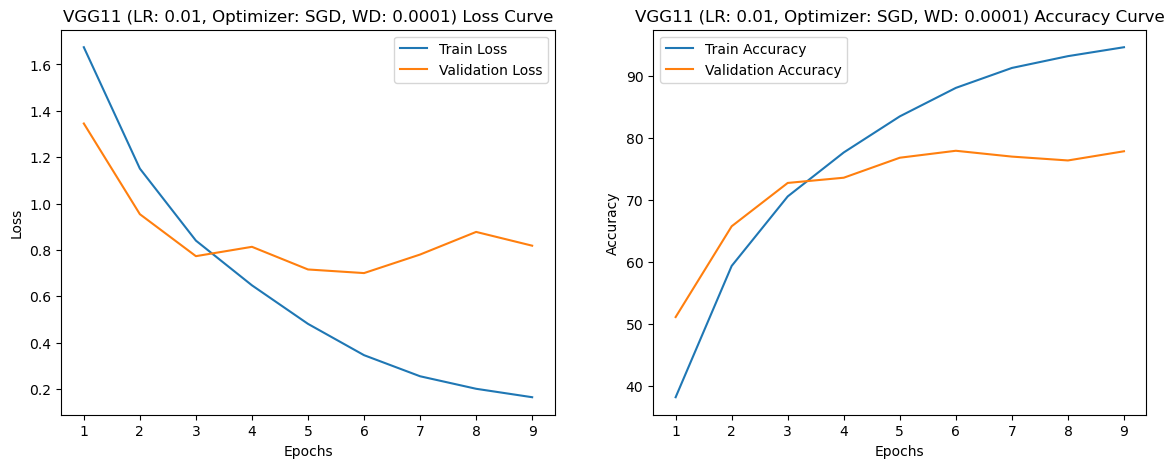


Training VGG11 with SGD optimizer, Learning Rate: 0.01, Weight Decay: 0.001


Epoch 1/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.09it/s]


Train Loss: 1.6963, Train Acc: 37.28%, Val Loss: 1.3457, Val Acc: 51.41%


Epoch 2/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.11it/s]


Train Loss: 1.1650, Train Acc: 58.53%, Val Loss: 0.9766, Val Acc: 65.60%


Epoch 3/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.10it/s]


Train Loss: 0.8526, Train Acc: 70.11%, Val Loss: 0.8039, Val Acc: 71.69%


Epoch 4/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.10it/s]


Train Loss: 0.6641, Train Acc: 77.05%, Val Loss: 0.7480, Val Acc: 73.93%


Epoch 5/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.11it/s]


Train Loss: 0.5245, Train Acc: 81.70%, Val Loss: 0.7385, Val Acc: 75.63%


Epoch 6/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.10it/s]


Train Loss: 0.4184, Train Acc: 85.63%, Val Loss: 0.6900, Val Acc: 78.19%


Epoch 7/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.10it/s]


Train Loss: 0.3286, Train Acc: 88.72%, Val Loss: 0.7619, Val Acc: 76.08%


Epoch 8/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.12it/s]


Train Loss: 0.2712, Train Acc: 90.78%, Val Loss: 0.7582, Val Acc: 77.29%


Epoch 9/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.11it/s]


Train Loss: 0.2352, Train Acc: 92.16%, Val Loss: 0.7935, Val Acc: 77.41%
Early stopping triggered


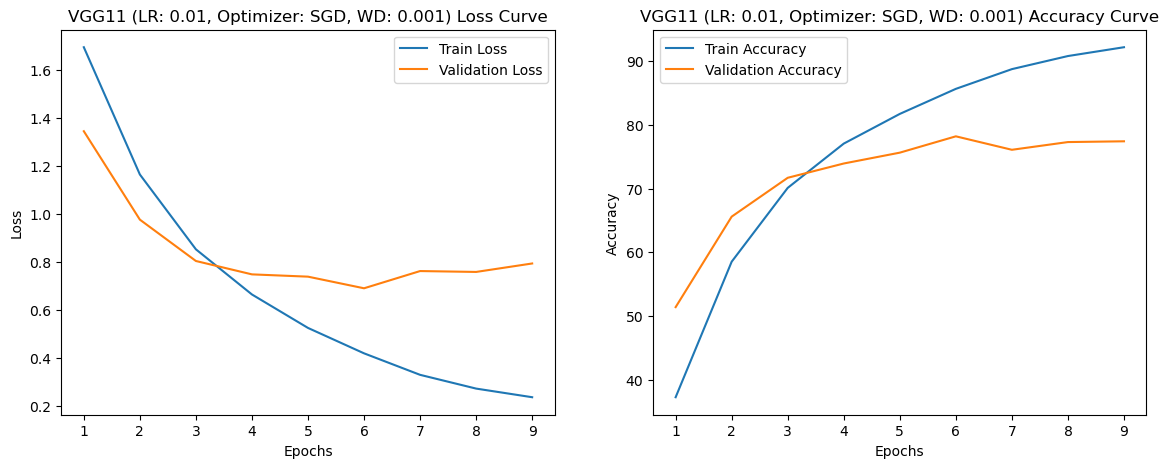


Training VGG11 with ADAM optimizer, Learning Rate: 0.001, Weight Decay: 0


Epoch 1/20: 100%|██████████| 1250/1250 [01:48<00:00, 11.51it/s]


Train Loss: 1.8100, Train Acc: 33.39%, Val Loss: 1.4354, Val Acc: 47.76%


Epoch 2/20: 100%|██████████| 1250/1250 [01:48<00:00, 11.53it/s]


Train Loss: 1.3474, Train Acc: 51.44%, Val Loss: 1.1703, Val Acc: 58.75%


Epoch 3/20: 100%|██████████| 1250/1250 [01:48<00:00, 11.54it/s]


Train Loss: 1.0916, Train Acc: 61.33%, Val Loss: 1.0243, Val Acc: 63.72%


Epoch 4/20: 100%|██████████| 1250/1250 [01:48<00:00, 11.54it/s]


Train Loss: 0.9468, Train Acc: 66.74%, Val Loss: 0.9332, Val Acc: 67.56%


Epoch 5/20: 100%|██████████| 1250/1250 [01:48<00:00, 11.54it/s]


Train Loss: 0.8439, Train Acc: 70.50%, Val Loss: 0.8684, Val Acc: 69.87%


Epoch 6/20: 100%|██████████| 1250/1250 [01:48<00:00, 11.53it/s]


Train Loss: 0.7561, Train Acc: 73.49%, Val Loss: 0.8539, Val Acc: 70.57%


Epoch 7/20: 100%|██████████| 1250/1250 [01:48<00:00, 11.55it/s]


Train Loss: 0.6660, Train Acc: 76.77%, Val Loss: 0.8522, Val Acc: 71.19%


Epoch 8/20: 100%|██████████| 1250/1250 [01:48<00:00, 11.56it/s]


Train Loss: 0.5892, Train Acc: 79.50%, Val Loss: 0.8563, Val Acc: 71.70%


Epoch 9/20: 100%|██████████| 1250/1250 [01:48<00:00, 11.53it/s]


Train Loss: 0.5272, Train Acc: 81.91%, Val Loss: 0.8070, Val Acc: 73.09%


Epoch 10/20: 100%|██████████| 1250/1250 [01:48<00:00, 11.54it/s]


Train Loss: 0.4629, Train Acc: 84.11%, Val Loss: 0.8182, Val Acc: 73.37%


Epoch 11/20: 100%|██████████| 1250/1250 [01:48<00:00, 11.56it/s]


Train Loss: 0.3996, Train Acc: 86.52%, Val Loss: 0.9457, Val Acc: 72.75%


Epoch 12/20: 100%|██████████| 1250/1250 [01:48<00:00, 11.54it/s]


Train Loss: 0.3649, Train Acc: 87.73%, Val Loss: 0.8787, Val Acc: 73.38%
Early stopping triggered


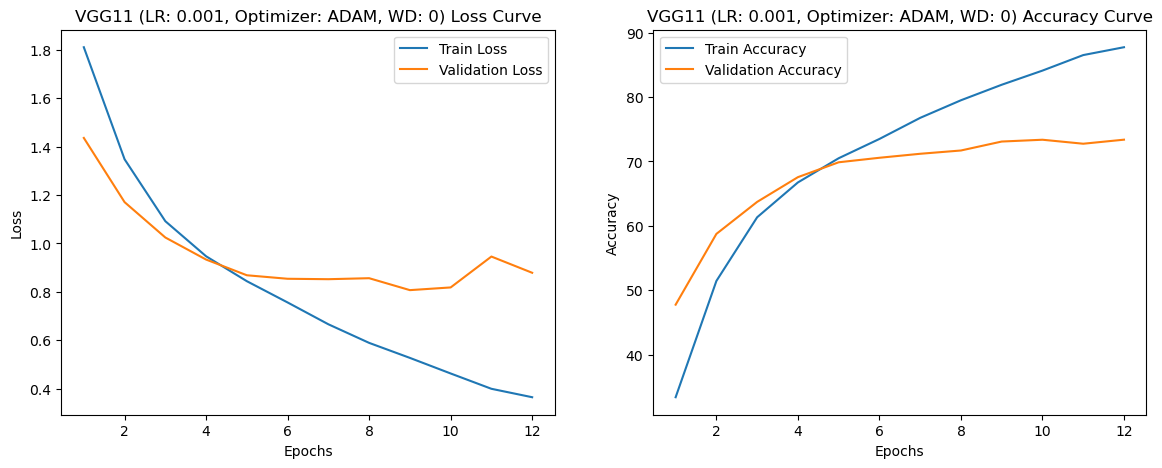


Training VGG11 with ADAM optimizer, Learning Rate: 0.001, Weight Decay: 0.0001


Epoch 1/20: 100%|██████████| 1250/1250 [01:50<00:00, 11.31it/s]


Train Loss: 2.3164, Train Acc: 9.78%, Val Loss: 2.3037, Val Acc: 10.01%


Epoch 2/20: 100%|██████████| 1250/1250 [01:50<00:00, 11.32it/s]


Train Loss: 2.3029, Train Acc: 10.07%, Val Loss: 2.3032, Val Acc: 9.71%


Epoch 3/20: 100%|██████████| 1250/1250 [01:50<00:00, 11.32it/s]


Train Loss: 2.3031, Train Acc: 9.91%, Val Loss: 2.3036, Val Acc: 9.40%


Epoch 4/20: 100%|██████████| 1250/1250 [01:50<00:00, 11.32it/s]


Train Loss: 2.3035, Train Acc: 9.98%, Val Loss: 2.3046, Val Acc: 9.81%


Epoch 5/20: 100%|██████████| 1250/1250 [01:50<00:00, 11.32it/s]


Train Loss: 2.3044, Train Acc: 9.93%, Val Loss: 2.3034, Val Acc: 10.37%
Early stopping triggered


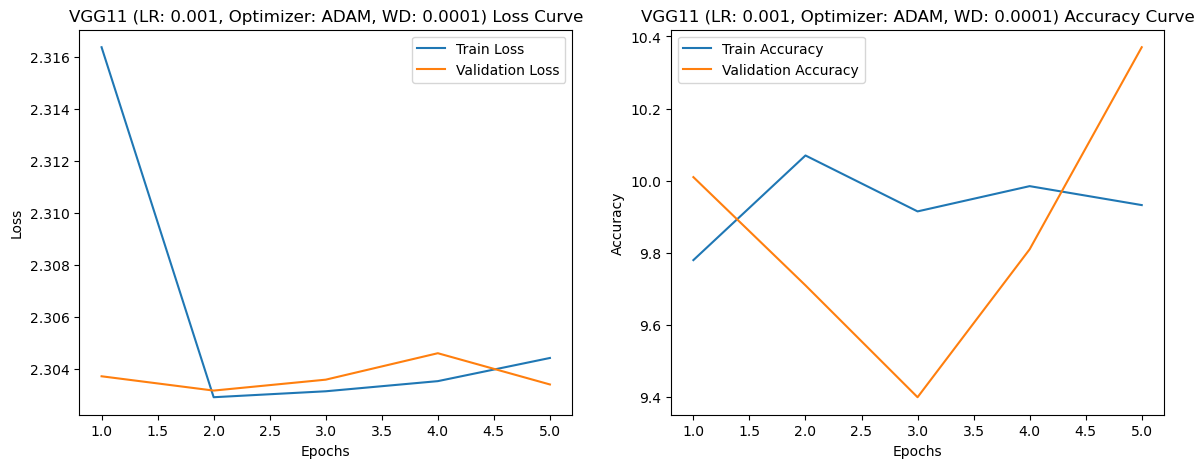


Training VGG11 with ADAM optimizer, Learning Rate: 0.001, Weight Decay: 0.001


Epoch 1/20: 100%|██████████| 1250/1250 [01:50<00:00, 11.31it/s]


Train Loss: 2.3127, Train Acc: 9.83%, Val Loss: 2.3027, Val Acc: 10.40%


Epoch 2/20: 100%|██████████| 1250/1250 [01:50<00:00, 11.32it/s]


Train Loss: 2.3042, Train Acc: 9.98%, Val Loss: 2.3085, Val Acc: 9.86%


Epoch 3/20: 100%|██████████| 1250/1250 [01:50<00:00, 11.32it/s]


Train Loss: 2.3045, Train Acc: 9.87%, Val Loss: 2.3044, Val Acc: 9.40%


Epoch 4/20: 100%|██████████| 1250/1250 [01:50<00:00, 11.31it/s]


Train Loss: 2.3042, Train Acc: 10.10%, Val Loss: 2.3050, Val Acc: 9.86%
Early stopping triggered


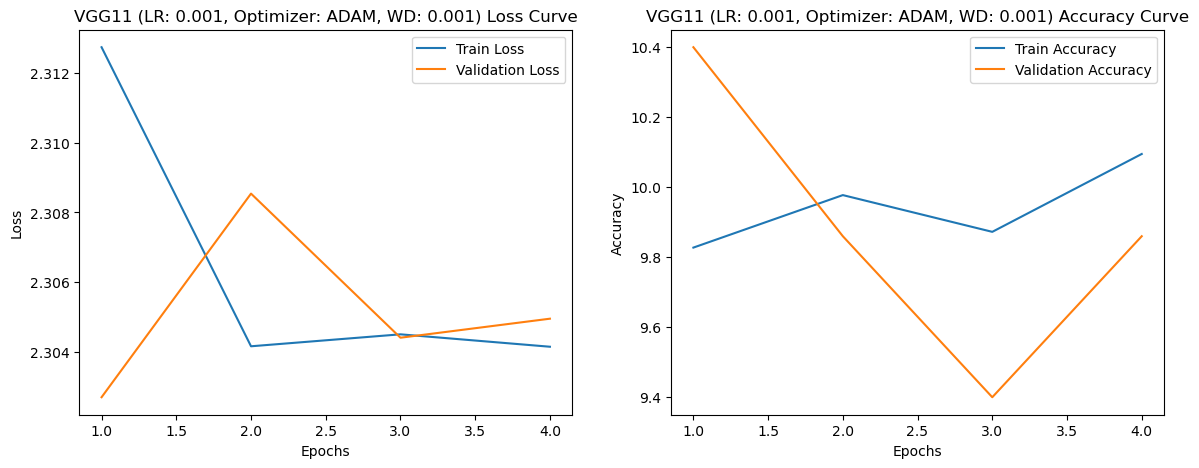


Training VGG11 with SGD optimizer, Learning Rate: 0.001, Weight Decay: 0


Epoch 1/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.32it/s]


Train Loss: 1.9528, Train Acc: 28.19%, Val Loss: 1.5761, Val Acc: 43.47%


Epoch 2/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.36it/s]


Train Loss: 1.5062, Train Acc: 45.18%, Val Loss: 1.3348, Val Acc: 51.32%


Epoch 3/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.33it/s]


Train Loss: 1.3234, Train Acc: 52.09%, Val Loss: 1.2274, Val Acc: 56.31%


Epoch 4/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.34it/s]


Train Loss: 1.1645, Train Acc: 57.98%, Val Loss: 1.0722, Val Acc: 61.85%


Epoch 5/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.35it/s]


Train Loss: 1.0267, Train Acc: 63.37%, Val Loss: 0.9652, Val Acc: 65.91%


Epoch 6/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.35it/s]


Train Loss: 0.8968, Train Acc: 68.17%, Val Loss: 0.9037, Val Acc: 68.35%


Epoch 7/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.33it/s]


Train Loss: 0.7763, Train Acc: 72.61%, Val Loss: 0.8882, Val Acc: 68.79%


Epoch 8/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.34it/s]


Train Loss: 0.6609, Train Acc: 76.76%, Val Loss: 0.7694, Val Acc: 73.90%


Epoch 9/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.34it/s]


Train Loss: 0.5540, Train Acc: 80.45%, Val Loss: 0.8356, Val Acc: 72.73%


Epoch 10/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.36it/s]


Train Loss: 0.4413, Train Acc: 84.39%, Val Loss: 0.7800, Val Acc: 74.15%


Epoch 11/20: 100%|██████████| 1250/1250 [01:41<00:00, 12.34it/s]


Train Loss: 0.3518, Train Acc: 87.51%, Val Loss: 0.8201, Val Acc: 74.25%
Early stopping triggered


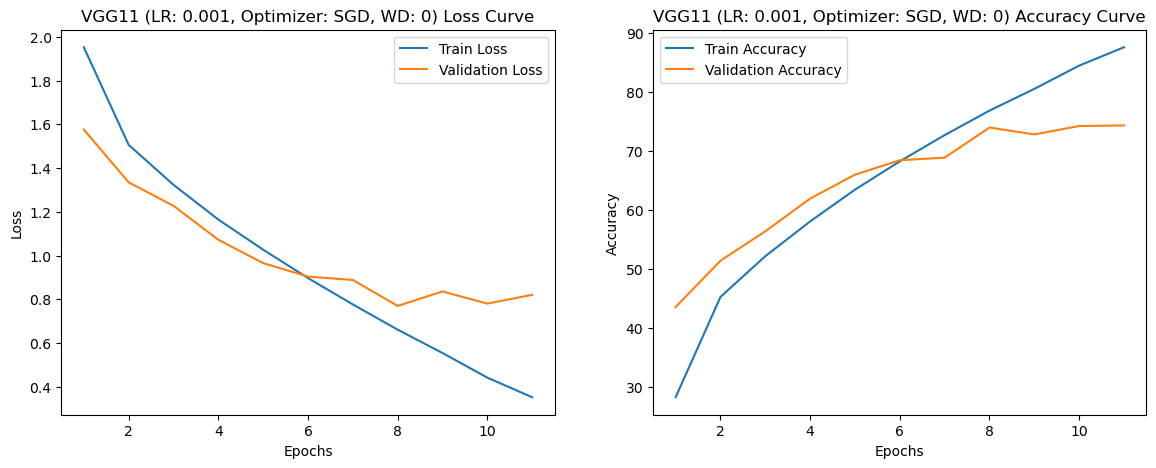


Training VGG11 with SGD optimizer, Learning Rate: 0.001, Weight Decay: 0.0001


Epoch 1/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.06it/s]


Train Loss: 1.9164, Train Acc: 29.92%, Val Loss: 1.5638, Val Acc: 42.66%


Epoch 2/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.09it/s]


Train Loss: 1.4762, Train Acc: 46.29%, Val Loss: 1.3325, Val Acc: 51.65%


Epoch 3/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.10it/s]


Train Loss: 1.2841, Train Acc: 53.49%, Val Loss: 1.1678, Val Acc: 57.68%


Epoch 4/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.08it/s]


Train Loss: 1.1288, Train Acc: 59.41%, Val Loss: 1.0484, Val Acc: 63.12%


Epoch 5/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.08it/s]


Train Loss: 0.9828, Train Acc: 65.20%, Val Loss: 0.9496, Val Acc: 66.61%


Epoch 6/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.09it/s]


Train Loss: 0.8521, Train Acc: 70.02%, Val Loss: 0.8738, Val Acc: 69.43%


Epoch 7/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.09it/s]


Train Loss: 0.7313, Train Acc: 74.22%, Val Loss: 0.8935, Val Acc: 69.30%


Epoch 8/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.08it/s]


Train Loss: 0.6252, Train Acc: 78.08%, Val Loss: 0.7845, Val Acc: 72.85%


Epoch 9/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.10it/s]


Train Loss: 0.5198, Train Acc: 81.57%, Val Loss: 0.7559, Val Acc: 74.90%


Epoch 10/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.12it/s]


Train Loss: 0.4150, Train Acc: 85.33%, Val Loss: 0.7956, Val Acc: 74.83%


Epoch 11/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.11it/s]


Train Loss: 0.3252, Train Acc: 88.57%, Val Loss: 0.8238, Val Acc: 75.51%


Epoch 12/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.09it/s]


Train Loss: 0.2505, Train Acc: 91.16%, Val Loss: 0.8619, Val Acc: 75.92%
Early stopping triggered


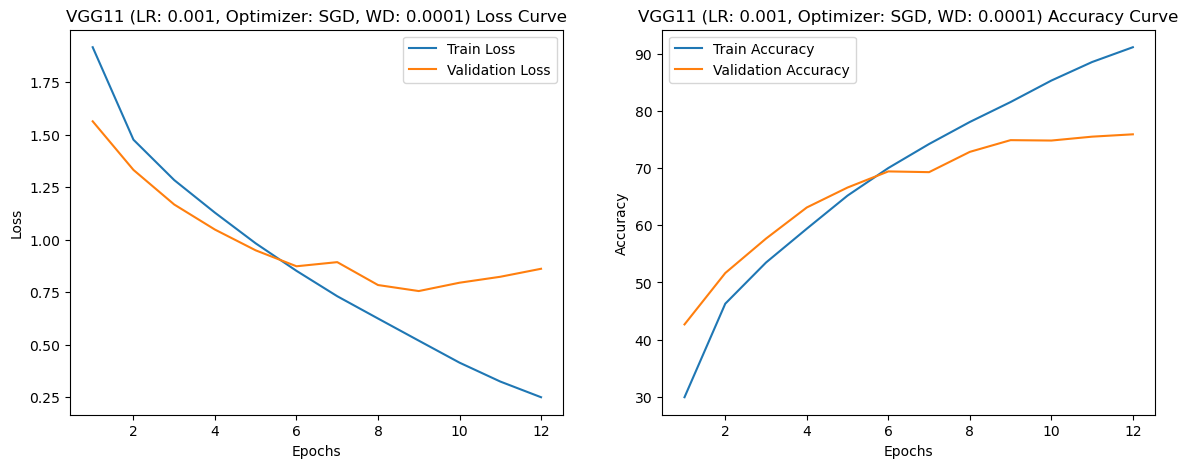


Training VGG11 with SGD optimizer, Learning Rate: 0.001, Weight Decay: 0.001


Epoch 1/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.08it/s]


Train Loss: 1.9373, Train Acc: 28.49%, Val Loss: 1.5697, Val Acc: 43.30%


Epoch 2/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.10it/s]


Train Loss: 1.4869, Train Acc: 45.69%, Val Loss: 1.3847, Val Acc: 49.29%


Epoch 3/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.12it/s]


Train Loss: 1.2963, Train Acc: 53.40%, Val Loss: 1.1643, Val Acc: 58.05%


Epoch 4/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.08it/s]


Train Loss: 1.1381, Train Acc: 59.33%, Val Loss: 1.0740, Val Acc: 61.28%


Epoch 5/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.09it/s]


Train Loss: 0.9912, Train Acc: 64.83%, Val Loss: 0.9468, Val Acc: 66.55%


Epoch 6/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.11it/s]


Train Loss: 0.8589, Train Acc: 69.57%, Val Loss: 0.8357, Val Acc: 70.61%


Epoch 7/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.11it/s]


Train Loss: 0.7339, Train Acc: 74.02%, Val Loss: 0.8432, Val Acc: 70.90%


Epoch 8/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.08it/s]


Train Loss: 0.6235, Train Acc: 78.25%, Val Loss: 0.7573, Val Acc: 73.65%


Epoch 9/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.09it/s]


Train Loss: 0.5134, Train Acc: 81.88%, Val Loss: 0.7958, Val Acc: 74.03%


Epoch 10/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.11it/s]


Train Loss: 0.4119, Train Acc: 85.44%, Val Loss: 0.7487, Val Acc: 74.92%


Epoch 11/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.11it/s]


Train Loss: 0.3199, Train Acc: 88.60%, Val Loss: 0.8267, Val Acc: 75.13%


Epoch 12/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.09it/s]


Train Loss: 0.2471, Train Acc: 91.31%, Val Loss: 0.8685, Val Acc: 74.95%


Epoch 13/20: 100%|██████████| 1250/1250 [01:43<00:00, 12.08it/s]


Train Loss: 0.1864, Train Acc: 93.56%, Val Loss: 0.8763, Val Acc: 75.85%
Early stopping triggered


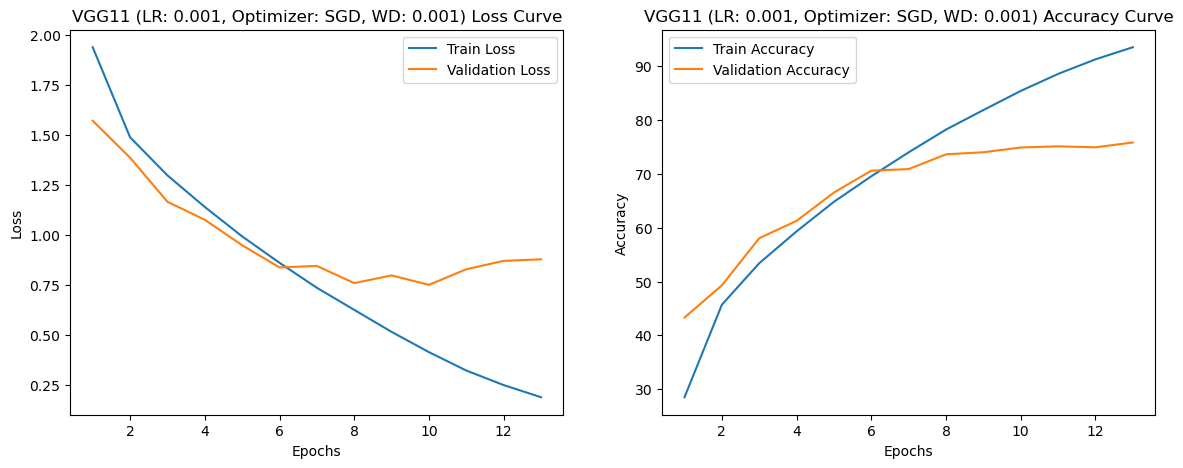


Best configuration for VGG11 - Optimizer: SGD, Learning Rate: 0.01, Weight Decay: 0.001, Validation Accuracy: 78.19%

Evaluating the best model (MobileNetV2) on the test set:
Best Model (MobileNetV2) Test Accuracy: 84.76%


In [8]:
# Hyperparameter tuning loop
best_models = {}
best_accuracies = {}

for model_name in ['ResNet18', 'MobileNetV2', 'VGG11']:
    best_val_acc = 0
    best_lr = None
    best_optimizer_name = None
    best_weight_decay = None
    best_model_state = None

    for lr in learning_rates:
        for optimizer_name in optimizers:
            for weight_decay in weight_decays:
                model = initialize_model(model_name)
                if optimizer_name == 'adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                elif optimizer_name == 'sgd':
                    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

                criterion = nn.CrossEntropyLoss()

                print(f"\nTraining {model_name} with {optimizer_name.upper()} optimizer, Learning Rate: {lr}, Weight Decay: {weight_decay}")
                train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(model, criterion, optimizer, train_loader, val_loader, num_epochs)

                if max(val_accuracies) > best_val_acc:
                    best_val_acc = max(val_accuracies)
                    best_lr = lr
                    best_optimizer_name = optimizer_name
                    best_weight_decay = weight_decay
                    best_model_state = model.state_dict()

                plot_learning_curve(train_losses, val_losses, train_accuracies, val_accuracies, f"{model_name} (LR: {lr}, Optimizer: {optimizer_name.upper()}, WD: {weight_decay})")

    print(f"\nBest configuration for {model_name} - Optimizer: {best_optimizer_name.upper()}, Learning Rate: {best_lr}, Weight Decay: {best_weight_decay}, Validation Accuracy: {best_val_acc:.2f}%")
    model.load_state_dict(best_model_state)
    best_models[model_name] = model
    best_accuracies[model_name] = best_val_acc

# Select the best model across all architectures
best_model_name = max(best_accuracies, key=best_accuracies.get)
best_model = best_models[best_model_name]

# Final evaluation on the test set
print(f"\nEvaluating the best model ({best_model_name}) on the test set:")
test_accuracy = evaluate_metrics(best_model, test_loader)
print(f"Best Model ({best_model_name}) Test Accuracy: {test_accuracy:.2f}%")

## Results of the best model


Evaluating the best model (MobileNetV2) on the test set:
Best Model (MobileNetV2) Test Accuracy: 84.76%

Per-class accuracy for the best model (MobileNetV2):


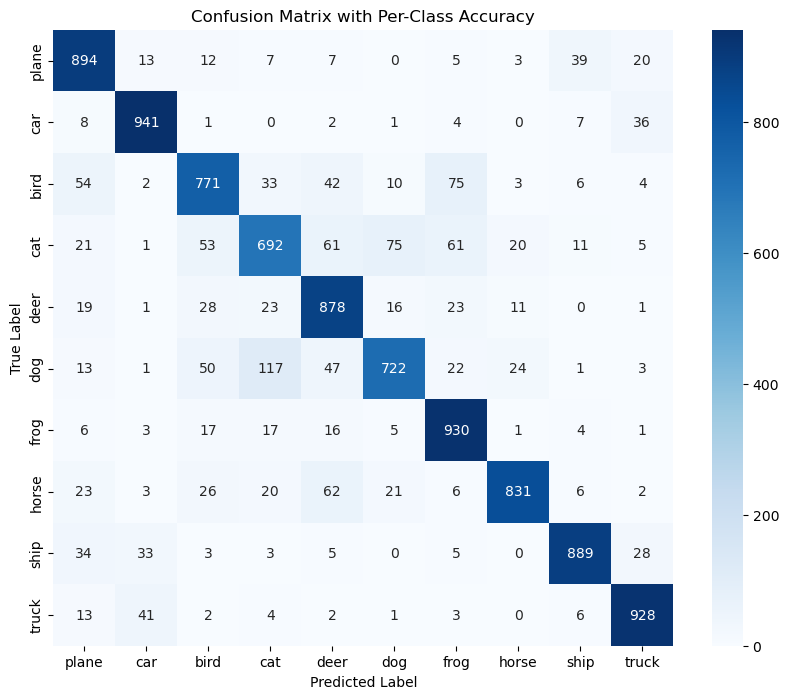

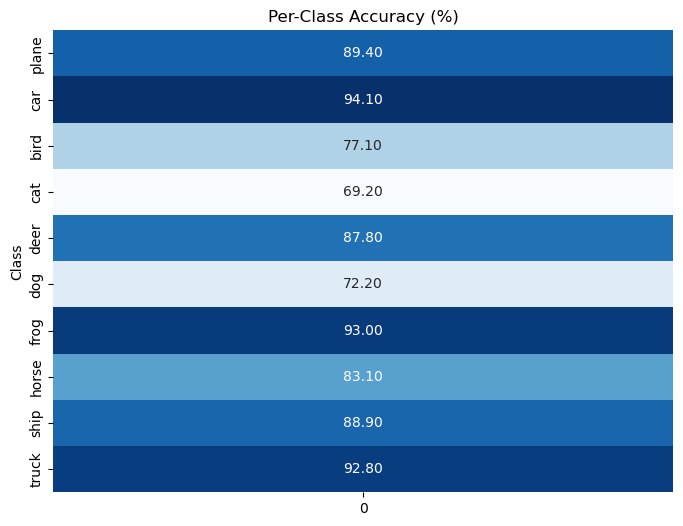

Per-class accuracy: [89.4 94.1 77.1 69.2 87.8 72.2 93.  83.1 88.9 92.8]


In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to calculate per-class accuracy and generate heatmap
def evaluate_per_class_accuracy(model, loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1) * 100

    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix with Per-Class Accuracy")
    plt.show()

    # Display per-class accuracy as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(per_class_accuracy.reshape(-1, 1), annot=True, cmap="Blues", yticklabels=class_names, cbar=False, fmt=".2f")
    plt.ylabel("Class")
    plt.title("Per-Class Accuracy (%)")
    plt.show()

    return per_class_accuracy

# Class names for CIFAR-10
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Final evaluation on the test set
print(f"\nEvaluating the best model ({best_model_name}) on the test set:")
test_accuracy = evaluate_metrics(best_model, test_loader)
print(f"Best Model ({best_model_name}) Test Accuracy: {test_accuracy:.2f}%")

# Generate heatmap for per-class accuracy
print(f"\nPer-class accuracy for the best model ({best_model_name}):")
per_class_accuracy = evaluate_per_class_accuracy(best_model, test_loader, class_names)
print(f"Per-class accuracy: {per_class_accuracy}")